<a href="https://colab.research.google.com/github/carol-akimi/Projeto-Trainee-Estat/blob/main/ProjetoTrainee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação de bibliotecas

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Upload do arquivo

In [ ]:
# Upload do arquivo CSV do computador
uploaded = files.upload()

# Leitura da base de dados
df = pd.read_csv("dados.csv")

Saving dados.csv to dados.csv


# Tratamento de valores faltantes e formatar colunas

In [ ]:
# Remoção de linhas duplicadas
df = df.drop_duplicates()

# Identificar colunas com valores ausentes
colunas_com_nulos = df.columns[df.isnull().any()]
print("Colunas com valores ausentes:", list(colunas_com_nulos))

# Quantidade de valores ausentes
for n in colunas_com_nulos:
  print(f"Valores ausentes de {n}: {df[n].isnull().sum()}")

# Estatísticas ANTES da imputação
print("\n Estatísticas ANTES da imputação (média, mediana, desvio padrão):\n")
antes_imputacao = df[colunas_com_nulos].select_dtypes(include=np.number).agg(['mean', 'median', 'std'])
print(antes_imputacao)

# Cópia do DataFrame original para preservar os dados
df_imputado = df.copy()

# Imputação de valores ausentes em colunas numéricas com MEDIANA
num_cols = df_imputado.select_dtypes(include=np.number).columns
imp_median = SimpleImputer(strategy='median')
df_imputado[num_cols] = imp_median.fit_transform(df_imputado[num_cols])

# Imputação de valores ausentes em colunas categóricas com MODA (mais frequente)
cat_cols = df_imputado.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    imp_mode = SimpleImputer(strategy='most_frequent')
    df_imputado[cat_cols] = imp_mode.fit_transform(df_imputado[cat_cols])
else:
    print("\n Nenhuma coluna categórica com nulos para imputar.")

# Estatísticas DEPOIS da imputação
print("\n Estatísticas DEPOIS da imputação:\n")
depois_imputacao = df_imputado[colunas_com_nulos].select_dtypes(include=np.number).agg(['mean', 'median', 'std'])
print(depois_imputacao)

# Comparação ANTES vs DEPOIS da imputação
print("\n Comparação das estatísticas ANTES vs DEPOIS da imputação:\n")
comparacao = pd.concat([antes_imputacao, depois_imputacao], keys=['Antes', 'Depois'])
print(comparacao)

# Identificar e retirar colunas com valores iguais e coluna de "ids"
df_imputado = df_imputado.drop('EmployeeNumber', axis = 1)
colunas_valores_iguais = df_imputado.columns[df_imputado.nunique() <= 1]
print(f"\nAs colunas retiradas foram: {colunas_valores_iguais.tolist()}")
df_imputado = df_imputado.drop(colunas_valores_iguais, axis = 1)

df_sem_cod = df_imputado.copy()

Colunas com valores ausentes: ['BusinessTravel', 'DistanceFromHome', 'EmployeeCount', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'OverTime', 'PerformanceRating']
Valores ausentes de BusinessTravel: 70
Valores ausentes de DistanceFromHome: 47
Valores ausentes de EmployeeCount: 220
Valores ausentes de EnvironmentSatisfaction: 53
Valores ausentes de Gender: 67
Valores ausentes de HourlyRate: 32
Valores ausentes de JobInvolvement: 61
Valores ausentes de OverTime: 51
Valores ausentes de PerformanceRating: 46

 Estatísticas ANTES da imputação (média, mediana, desvio padrão):

        DistanceFromHome  EmployeeCount  EnvironmentSatisfaction  HourlyRate  \
mean            9.188335            1.0                 2.717713   65.907510   
median          7.000000            1.0                 3.000000   66.000000   
std             8.133707            0.0                 1.092826   20.386193   

        JobInvolvement  PerformanceRating  
mean          2.732434          

# Tratamento de variáveis categóricas
* Variáveis com apenas dois valores como Gender, Attrition foi feito usado o label_encoder que transforma os valores em 0 e 1
* Váriáveis com mais valores como EducationField foi feito o one hot encoder

In [ ]:
# Codificação de dados categóricos
categoricas = [col for col in df_imputado.columns if df_imputado[col].dtype == 'object']
for col in categoricas:
  if (df_imputado[col].nunique() == 2):  # Se são apenas dois valores faz label encoding
    label_encoder = LabelEncoder()
    df_imputado[col] = label_encoder.fit_transform(df_imputado[col])
  else:
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Se não, faz One-hot encoder
    one_hot_encoded = one_hot_encoder.fit_transform(df_imputado[[col]])
    col_nomes = one_hot_encoder.get_feature_names_out([col])  # Pega o nome das colunas
    encoded_df = pd.DataFrame(one_hot_encoded, columns=col_nomes, index=df_imputado.index) # Cria DataFrame com as colunas codificadas
    df_imputado = df_imputado.drop(columns=[col]).join(encoded_df)

# Tratamento de outliers

In [ ]:
"""
Conta a quantidade de outliers de uma coluna
Retorna a quantidade de outliers da coluna
"""
def outliers_iqr(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lim_inf = q1 - 1.5 * iqr
  lim_sup = q3 + 1.5 * iqr
  return ((df[col] < lim_inf) | (df[col] > lim_sup))


In [ ]:
"""
Calcula a porcentagem que os outliers representam em relação aos dados
Retorna a porcentagem de outliers da coluna
"""
def porcentagem_outliers(df, col, outliers):
  if (outliers > 0):
    return (outliers/df[col].dropna().shape[0])*100


In [ ]:
col_outliers = {} # Armazena a coluna e a porcentagem de outliers
for col in df_imputado.columns:
  porcentagem = porcentagem_outliers(df_imputado, col, outliers_iqr(df_imputado, col).sum())
  if (df_imputado[col].nunique() > 2 and porcentagem != None):
    col_outliers[col] = porcentagem
    print(f"A porcentagem de outliers é {col}: {porcentagem}")

A porcentagem de outliers é MonthlyIncome: 7.755102040816326
A porcentagem de outliers é NumCompaniesWorked: 3.537414965986395
A porcentagem de outliers é StockOptionLevel: 5.782312925170068
A porcentagem de outliers é TotalWorkingYears: 4.285714285714286
A porcentagem de outliers é TrainingTimesLastYear: 16.19047619047619
A porcentagem de outliers é YearsAtCompany: 7.07482993197279
A porcentagem de outliers é YearsInCurrentRole: 1.4285714285714286
A porcentagem de outliers é YearsSinceLastPromotion: 7.278911564625851
A porcentagem de outliers é YearsWithCurrManager: 0.9523809523809524


In [ ]:
# Retirei a coluna 'TrainingTimesLastYear' que apresentava uma elevada quantidade de outliers, e sua correlação com o target não é significativa.
df_imputado = df_imputado.drop('TrainingTimesLastYear', axis = 1)
del col_outliers['TrainingTimesLastYear']

In [ ]:
"""
Trata os outliers a depender da porcentagem que eles representam
df: DataFrame
outliers: Dicionário das colunas e porcentagem de outliers
"""

def tratar_outliers(df, outliers, substituicao):
  df_sem_outliers = df.copy()
  for col in outliers.keys():
    if (substituicao == 'media'):
      df_sem_outliers[col] = df_sem_outliers[col].mask(outliers_iqr(df_sem_outliers, col), df_sem_outliers[col].mean())
    else:
      df_sem_outliers[col] = df_sem_outliers[col].mask(outliers_iqr(df_sem_outliers, col), df_sem_outliers[col].median())
  return df_sem_outliers



In [ ]:
def comparar_histogramas(df_original, df_media, df_mediana, col_outliers):
    """
    Plota histogramas e curvas de densidade lado a lado para cada coluna:
    - Esquerda: comparação original vs média
    - Direita: comparação original vs mediana
    """
    n = len(col_outliers)
    fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(16, 5 * n), constrained_layout=True)

    for i, col in enumerate(col_outliers.keys()):
        # Esquerda: Média
        ax1 = axs[i][0]
        ax1.hist(df_original[col], bins=30, alpha=0.5, label='Original', density=True, color='skyblue')
        ax1.hist(df_media[col], bins=30, alpha=0.5, label='Média', density=True, color='maroon')
        sns.kdeplot(df_original[col].dropna(), ax=ax1, lw=2, label='Densidade original', color='blue')
        sns.kdeplot(df_media[col].dropna(), ax=ax1, lw=2, label='Densidade média', color='maroon')
        ax1.set_title(f"{col} - Imputação com Média")
        ax1.set_xlabel(col)
        ax1.set_ylabel('Densidade')
        ax1.legend()
        sns.despine(ax=ax1)

        # Direita: Mediana
        ax2 = axs[i][1]
        ax2.hist(df_original[col], bins=30, alpha=0.5, label='Original', density=True, color='skyblue')
        ax2.hist(df_mediana[col], bins=30, alpha=0.5, label='Mediana', density=True, color='indianred')
        sns.kdeplot(df_original[col].dropna(), ax=ax2, lw=2, label='Densidade original', color='blue')
        sns.kdeplot(df_mediana[col].dropna(), ax=ax2, lw=2, label='Densidade mediana', color='indianred')
        ax2.set_title(f"{col} - Imputação com Mediana")
        ax2.set_xlabel(col)
        ax2.set_ylabel('Densidade')
        ax2.legend()
        sns.despine(ax=ax2)
    plt.show()


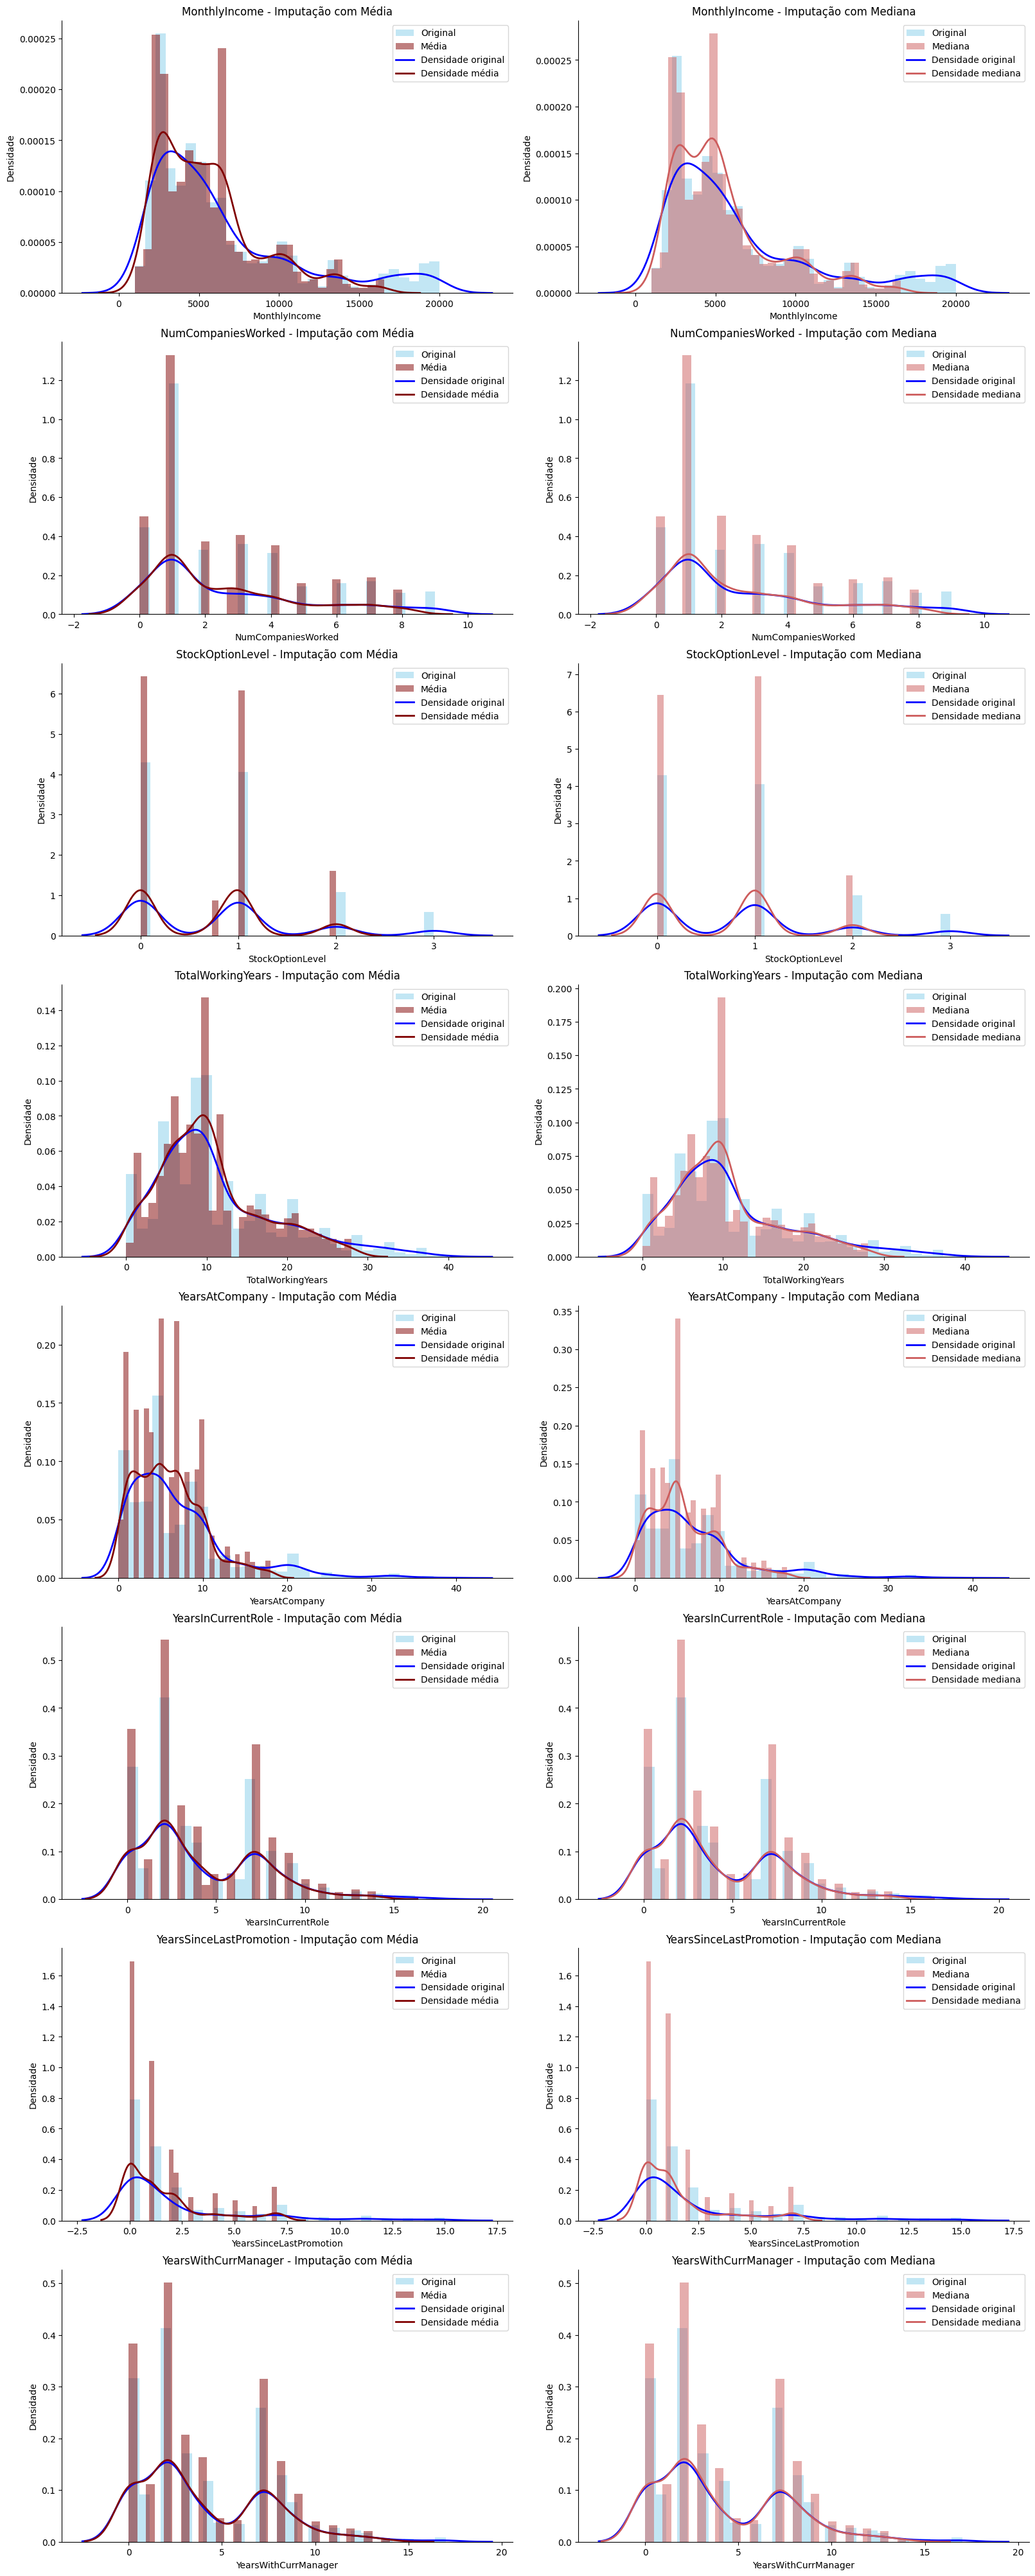

In [ ]:
df_media = tratar_outliers(df_imputado, col_outliers, 'media')
df_mediana = tratar_outliers(df_imputado, col_outliers, 'mediana')
comparar_histogramas(df_imputado, df_media, df_mediana, col_outliers)


In [ ]:
print(f"{'Coluna':<25} {'Desvio Padrão Original':<25} {'Imputação com média':<25} {'Imputação com mediana':<25}")
for col in col_outliers:
    std_original = df_imputado[col].std()
    std_media = df_media[col].std()
    std_mediana = df_mediana[col].std()
    print(f"{col:<25} {std_original:<25.2f} {std_media:<25.2f} {std_mediana:<25.2f}")



Coluna                    Desvio Padrão Original    Imputação com média       Imputação com mediana    
MonthlyIncome             4707.96                   3199.64                   3192.26                  
NumCompaniesWorked        2.50                      2.19                      2.19                     
StockOptionLevel          0.85                      0.65                      0.66                     
TotalWorkingYears         7.78                      6.31                      6.31                     
YearsAtCompany            6.13                      3.89                      3.88                     
YearsInCurrentRole        3.62                      3.33                      3.33                     
YearsSinceLastPromotion   3.22                      1.93                      1.93                     
YearsWithCurrManager      3.57                      3.37                      3.37                     


# Análise Exploratória de dados

In [ ]:
print(" Estatísticas descritivas para variáveis numéricas:")
display(df_imputado.describe().T)

 Estatísticas descritivas para variáveis numéricas:


count          mean          std     min  \
Age                                1470.0     36.923810     9.135373    18.0   
Attrition                          1470.0      0.161224     0.367863     0.0   
DailyRate                          1470.0    802.485714   403.509100   102.0   
DistanceFromHome                   1470.0      9.118367     8.011794     1.0   
Education                          1470.0      2.912925     1.024165     1.0   
EnvironmentSatisfaction            1470.0      2.727891     1.074222     1.0   
Gender                             1470.0      0.621088     0.485281     0.0   
HourlyRate                         1470.0     65.909524    20.162933    30.0   
JobInvolvement                     1470.0      2.743537     0.694387     1.0   
JobLevel                           1470.0      2.063946     1.106940     1.0   
JobSatisfaction                    1470.0      2.728571     1.102846     1.0   
MonthlyIncome                      1470.0   6502.931293  4707.956783  1009.0   
MonthlyRate                        1470.0  14313.103401  7117.786044  2094.0   
NumCompaniesWorked                 1470.0      2.693197     2.498009     0.0   
OverTime                           1470.0      0.272109     0.445197     0.0   
PercentSalaryHike                  1470.0     15.209524     3.659938    11.0   
PerformanceRating                  1470.0      3.145578     0.352803     3.0   
RelationshipSatisfaction           1470.0      2.712245     1.081209     1.0   
StockOptionLevel                   1470.0      0.793878     0.852077     0.0   
TotalWorkingYears                  1470.0     11.279592     7.780782     0.0   
WorkLifeBalance                    1470.0      2.761224     0.706476     1.0   
YearsAtCompany                     1470.0      7.008163     6.126525     0.0   
YearsInCurrentRole                 1470.0      4.229252     3.623137     0.0   
YearsSinceLastPromotion            1470.0      2.187755     3.222430     0.0   
YearsWithCurrManager               1470.0      4.123129     3.568136     0.0   
BusinessTravel_Non-Travel          1470.0      0.099320     0.299193     0.0   
BusinessTravel_Travel_Frequently   1470.0      0.180272     0.384545     0.0   
BusinessTravel_Travel_Rarely       1470.0      0.720408     0.448951     0.0   
Department_Human Resources         1470.0      0.042857     0.202604     0.0   
Department_Research & Development  1470.0      0.653741     0.475939     0.0   
Department_Sales                   1470.0      0.303401     0.459884     0.0   
EducationField_Human Resources     1470.0      0.018367     0.134321     0.0   
EducationField_Life Sciences       1470.0      0.412245     0.492406     0.0   
EducationField_Marketing           1470.0      0.108163     0.310692     0.0   
EducationField_Medical             1470.0      0.315646     0.464931     0.0   
EducationField_Other               1470.0      0.055782     0.229579     0.0   
EducationField_Technical Degree    1470.0      0.089796     0.285986     0.0   
JobRole_Healthcare Representative  1470.0      0.089116     0.285008     0.0   
JobRole_Human Resources            1470.0      0.035374     0.184786     0.0   
JobRole_Laboratory Technician      1470.0      0.176190     0.381112     0.0   
JobRole_Manager                    1470.0      0.069388     0.254199     0.0   
JobRole_Manufacturing Director     1470.0      0.098639     0.298279     0.0   
JobRole_Research Director          1470.0      0.054422     0.226925     0.0   
JobRole_Research Scientist         1470.0      0.198639     0.399112     0.0   
JobRole_Sales Executive            1470.0      0.221769     0.415578     0.0   
JobRole_Sales Representative       1470.0      0.056463     0.230891     0.0   
MaritalStatus_Divorced             1470.0      0.222449     0.416033     0.0   
MaritalStatus_Married              1470.0      0.457823     0.498387     0.0   
MaritalStatus_Single               1470.0      0.319728     0.466530     0.0   

                                   

In [ ]:
"""
Faz um boxplot para cada coluna do DataFrame

"""
def BoxPlot(df, col=4):
  # Determina os parâmetros da imagem
  num_cols = [col for col in df.columns if df[col].nunique() > 2]
  n = len(num_cols)
  nrows = (n + col - 1) // col  # só o necessário
  # Determina os parâmetros da imagem
  fig, axs = plt.subplots(nrows = nrows, ncols = col, figsize=(20, 25), constrained_layout = True)
  axs = axs.flatten()
  for i, col in enumerate(num_cols):
    axs[i].boxplot(df[col].dropna())
    axs[i].set_title(f"Boxplot: {col}")
    axs[i].set_ylabel('Valores')
    # Se tiver menos eixos do que colunas, esconder eixos extras

  for j in range(i+1, len(axs)):
      axs[j].set_visible(False)

  plt.show()

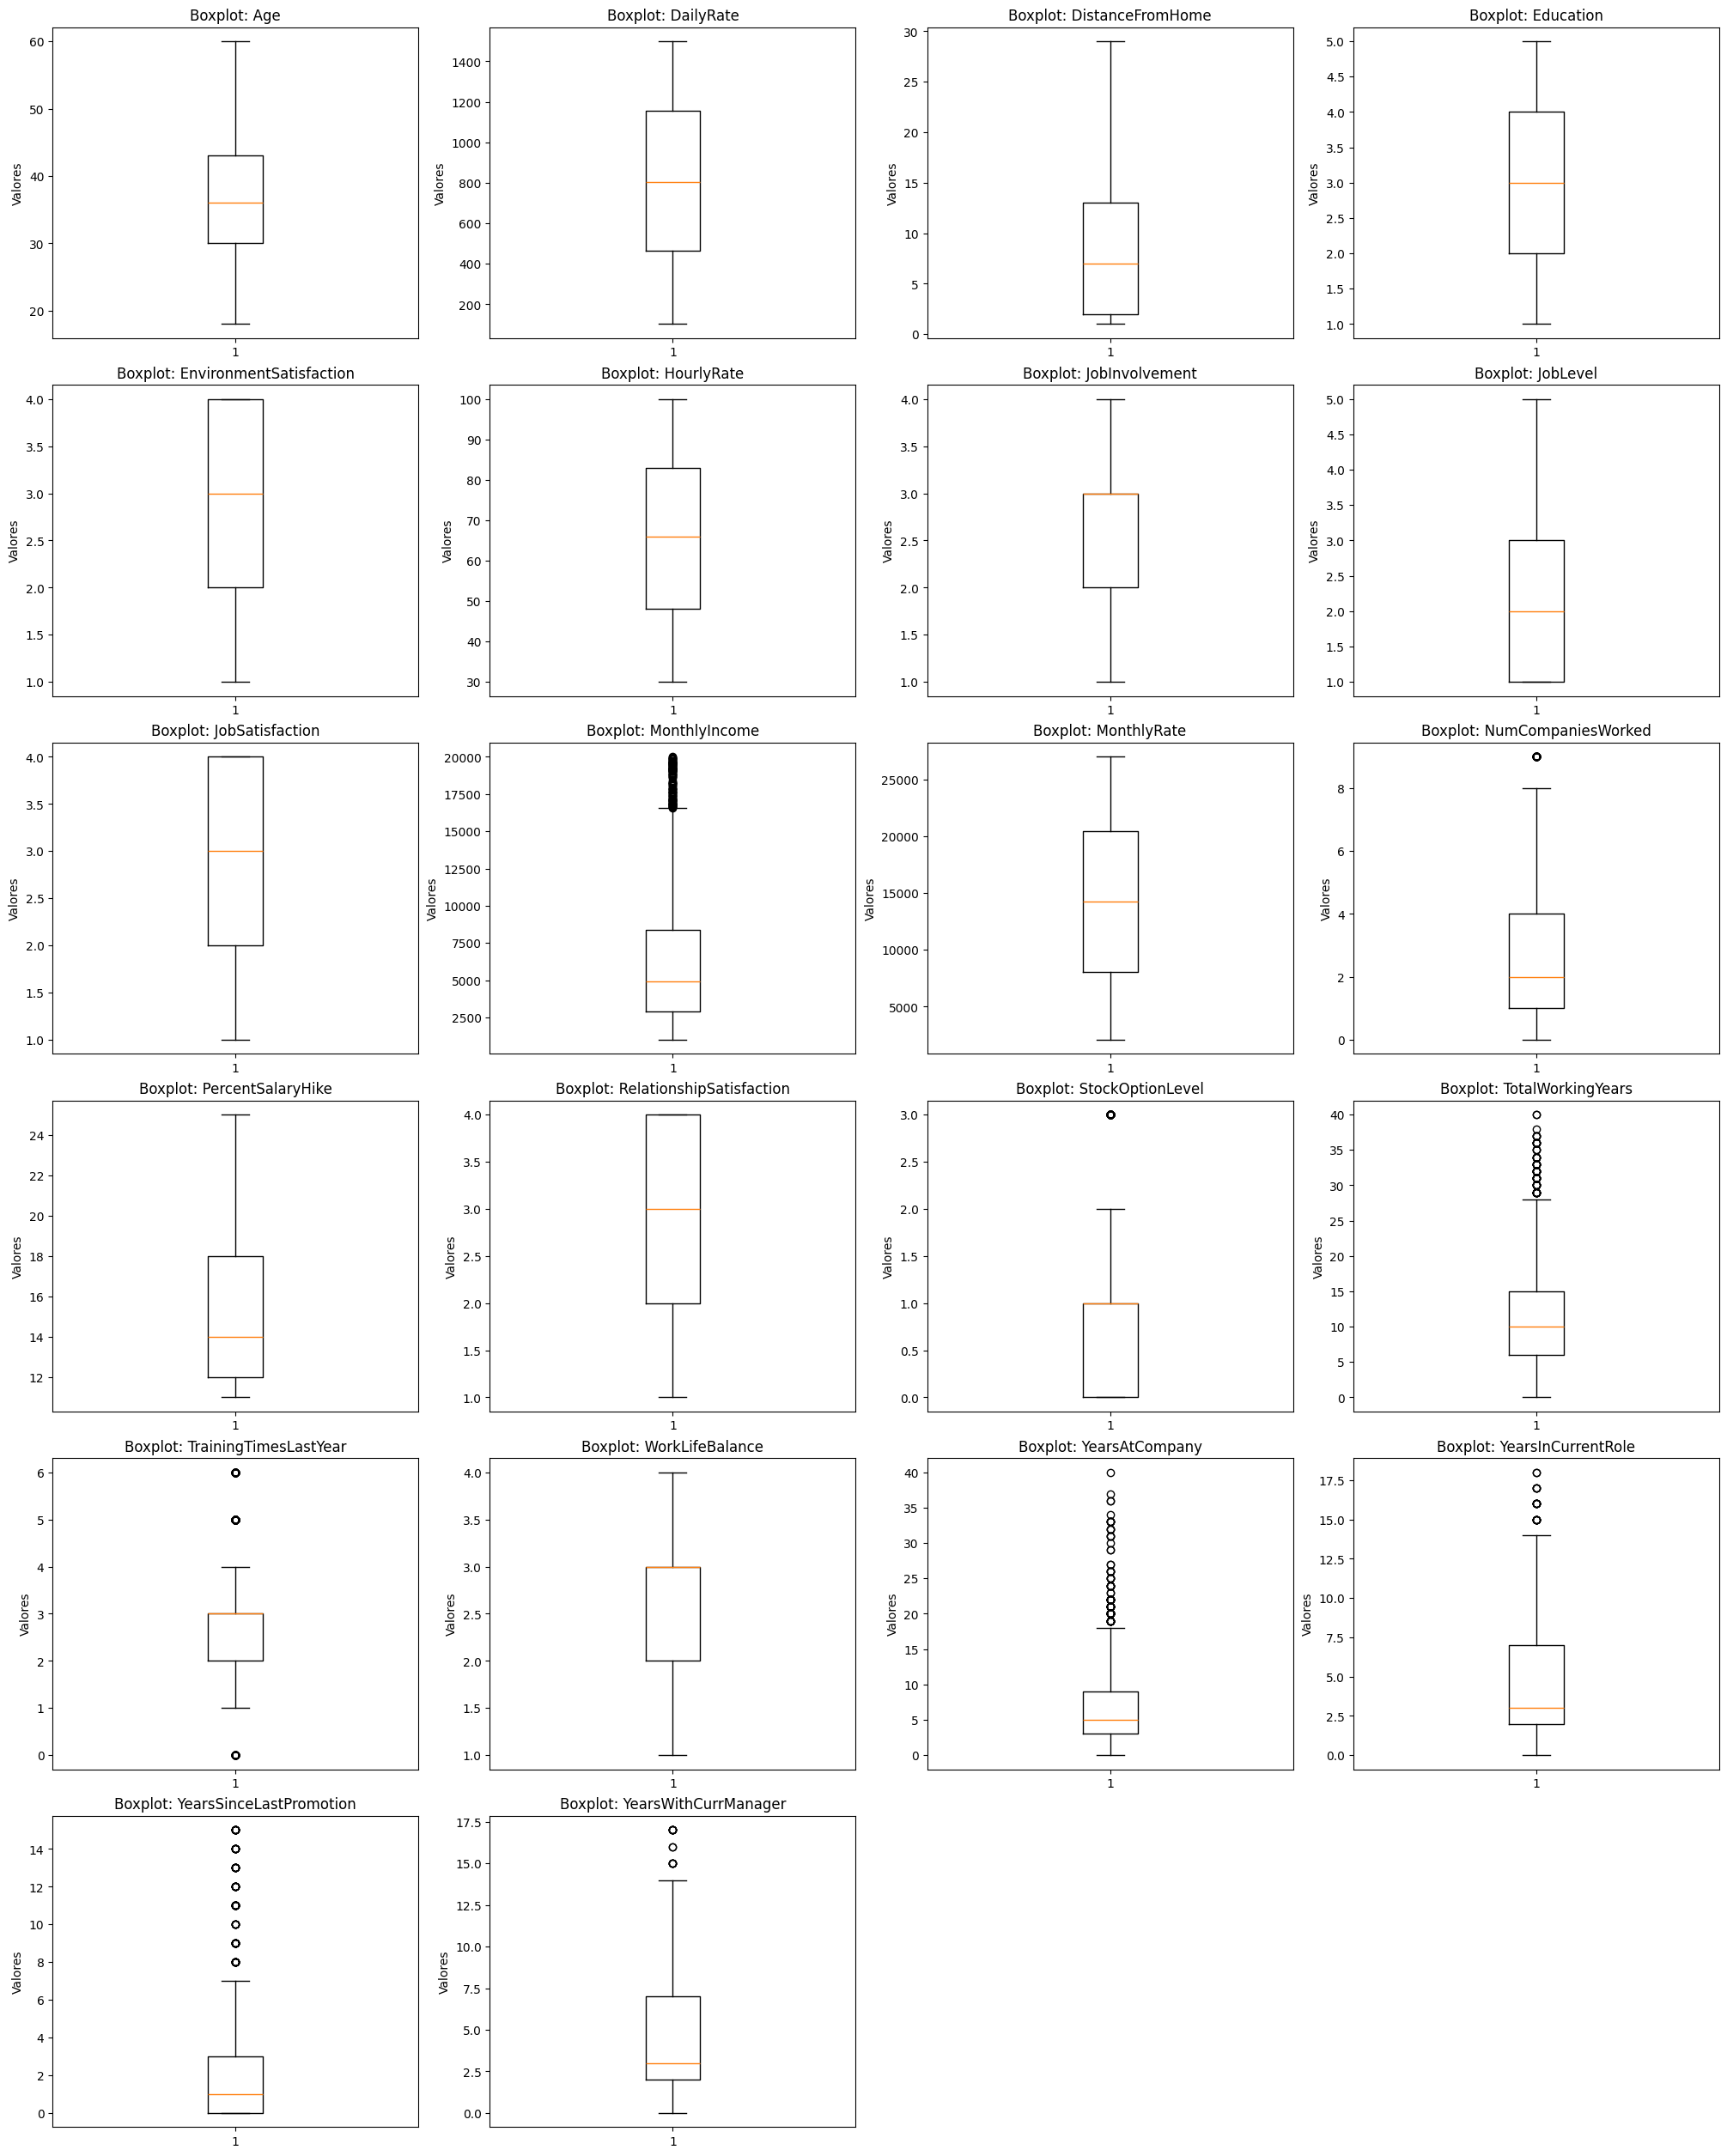

In [ ]:
BoxPlot(df_imputado)

In [ ]:
"""
Faz histogramas com linhas de densidade para cada coluna do DataFrame
"""
def Histogramas(df, lin=10, col=5):
  # Determina os parâmetros da imagem
  fig, axs = plt.subplots(nrows = lin, ncols = col, figsize=(25, 30), constrained_layout = True)
  axs = axs.flatten()
  for i, col in enumerate(df.columns):
    axs[i].hist(df[col], bins=30, density=True, label=col, color='skyblue')
    sns.kdeplot(df_imputado[col].dropna(), ax=axs[i], lw=2, label='Densidade', color='maroon')
    sns.despine()   # Remove bordas desnecessárias
    axs[i].set_title(f"Histograma + Densidade: {col}")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Valores')
  plt.show()


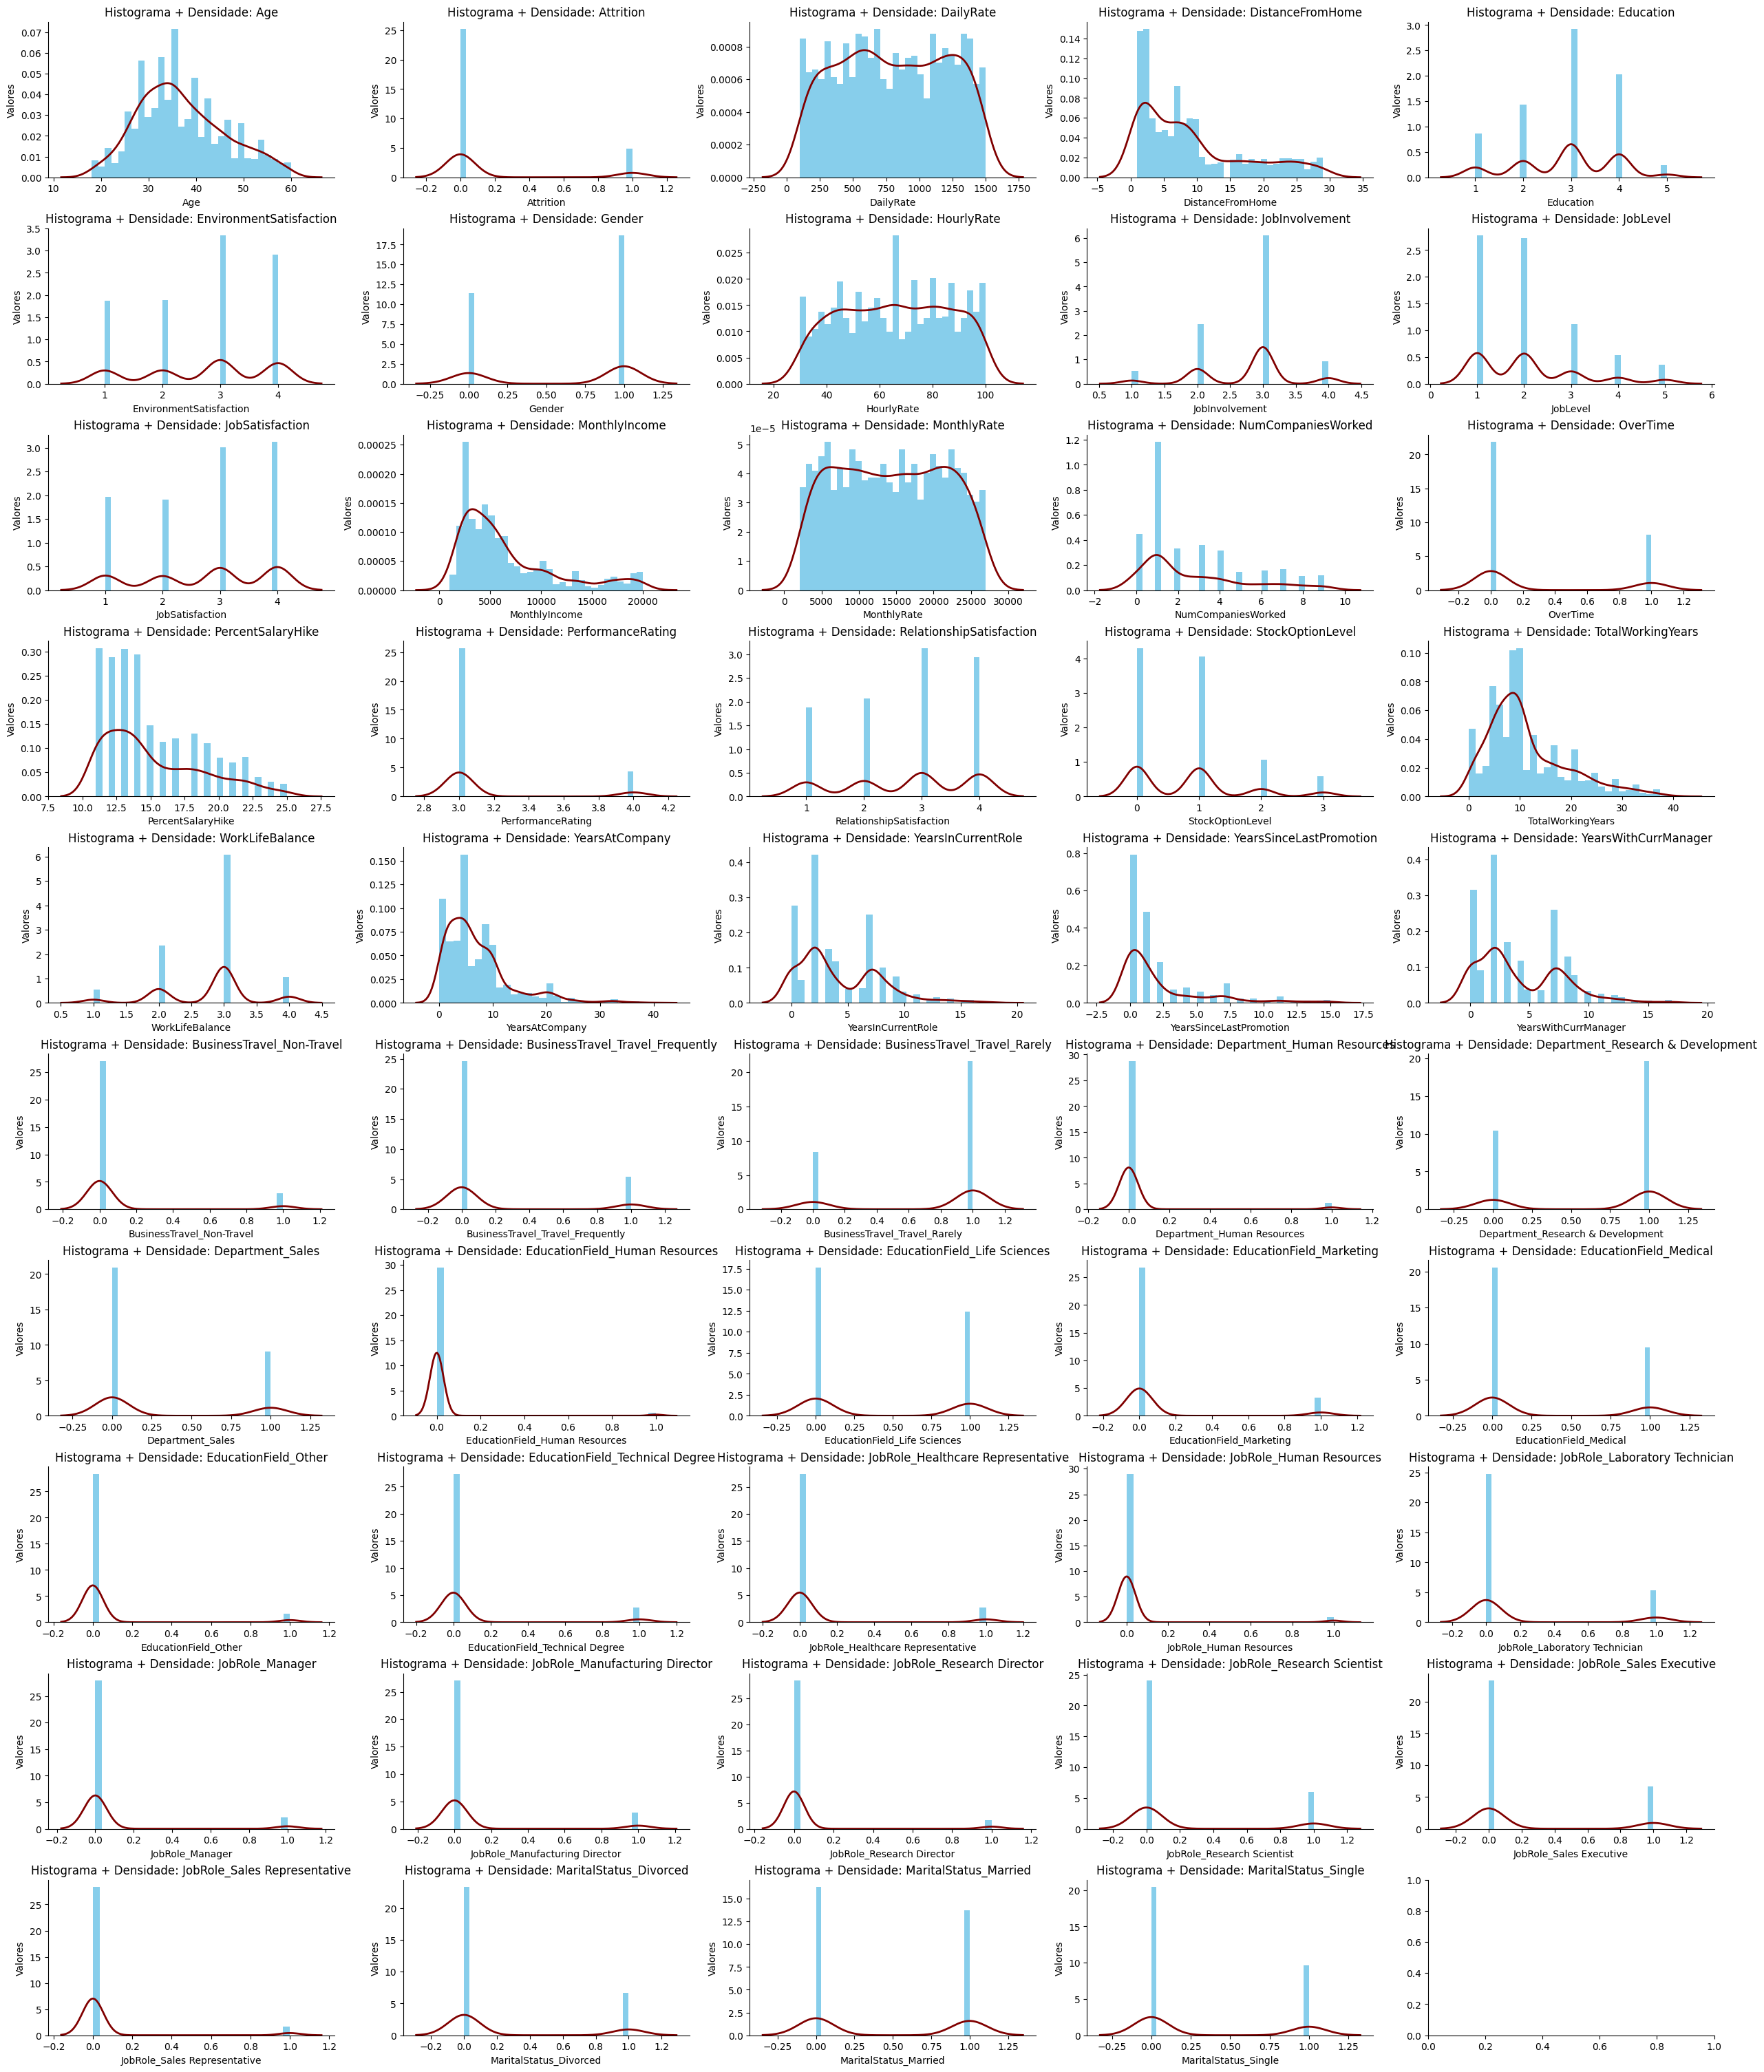

In [ ]:
Histogramas(df_imputado)

# Gráfico de frequência
* Gráfico de frequência para variáveis categóricas

In [ ]:
"""
Gráfico de frequência para variáveis categóricas
"""
def grafico_frequencia(df, col=4):
  cat_cols = [col for col in df.columns if df[col].dtype == 'object']
  n = len(cat_cols)
  nrows = (n + col - 1) // col  # só o necessário
  fig, axs = plt.subplots(nrows = nrows, ncols = col, figsize=(25, 15), constrained_layout = True)
  axs = axs.flatten()
  for i, col in enumerate(cat_cols):
    if (df[col].dtype == 'object'):
      contagem = df[col].value_counts().sort_index()
      axs[i].bar(contagem.index.astype(str), contagem.values, color='lightskyblue')
      axs[i].set_title(f'{col}')
      axs[i].set_xlabel(col)
      axs[i].set_ylabel('Frequência')
      axs[i].tick_params(axis='x', rotation=45)
  for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
  plt.tight_layout()
  plt.show()


<ipython-input-59-251568277>:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


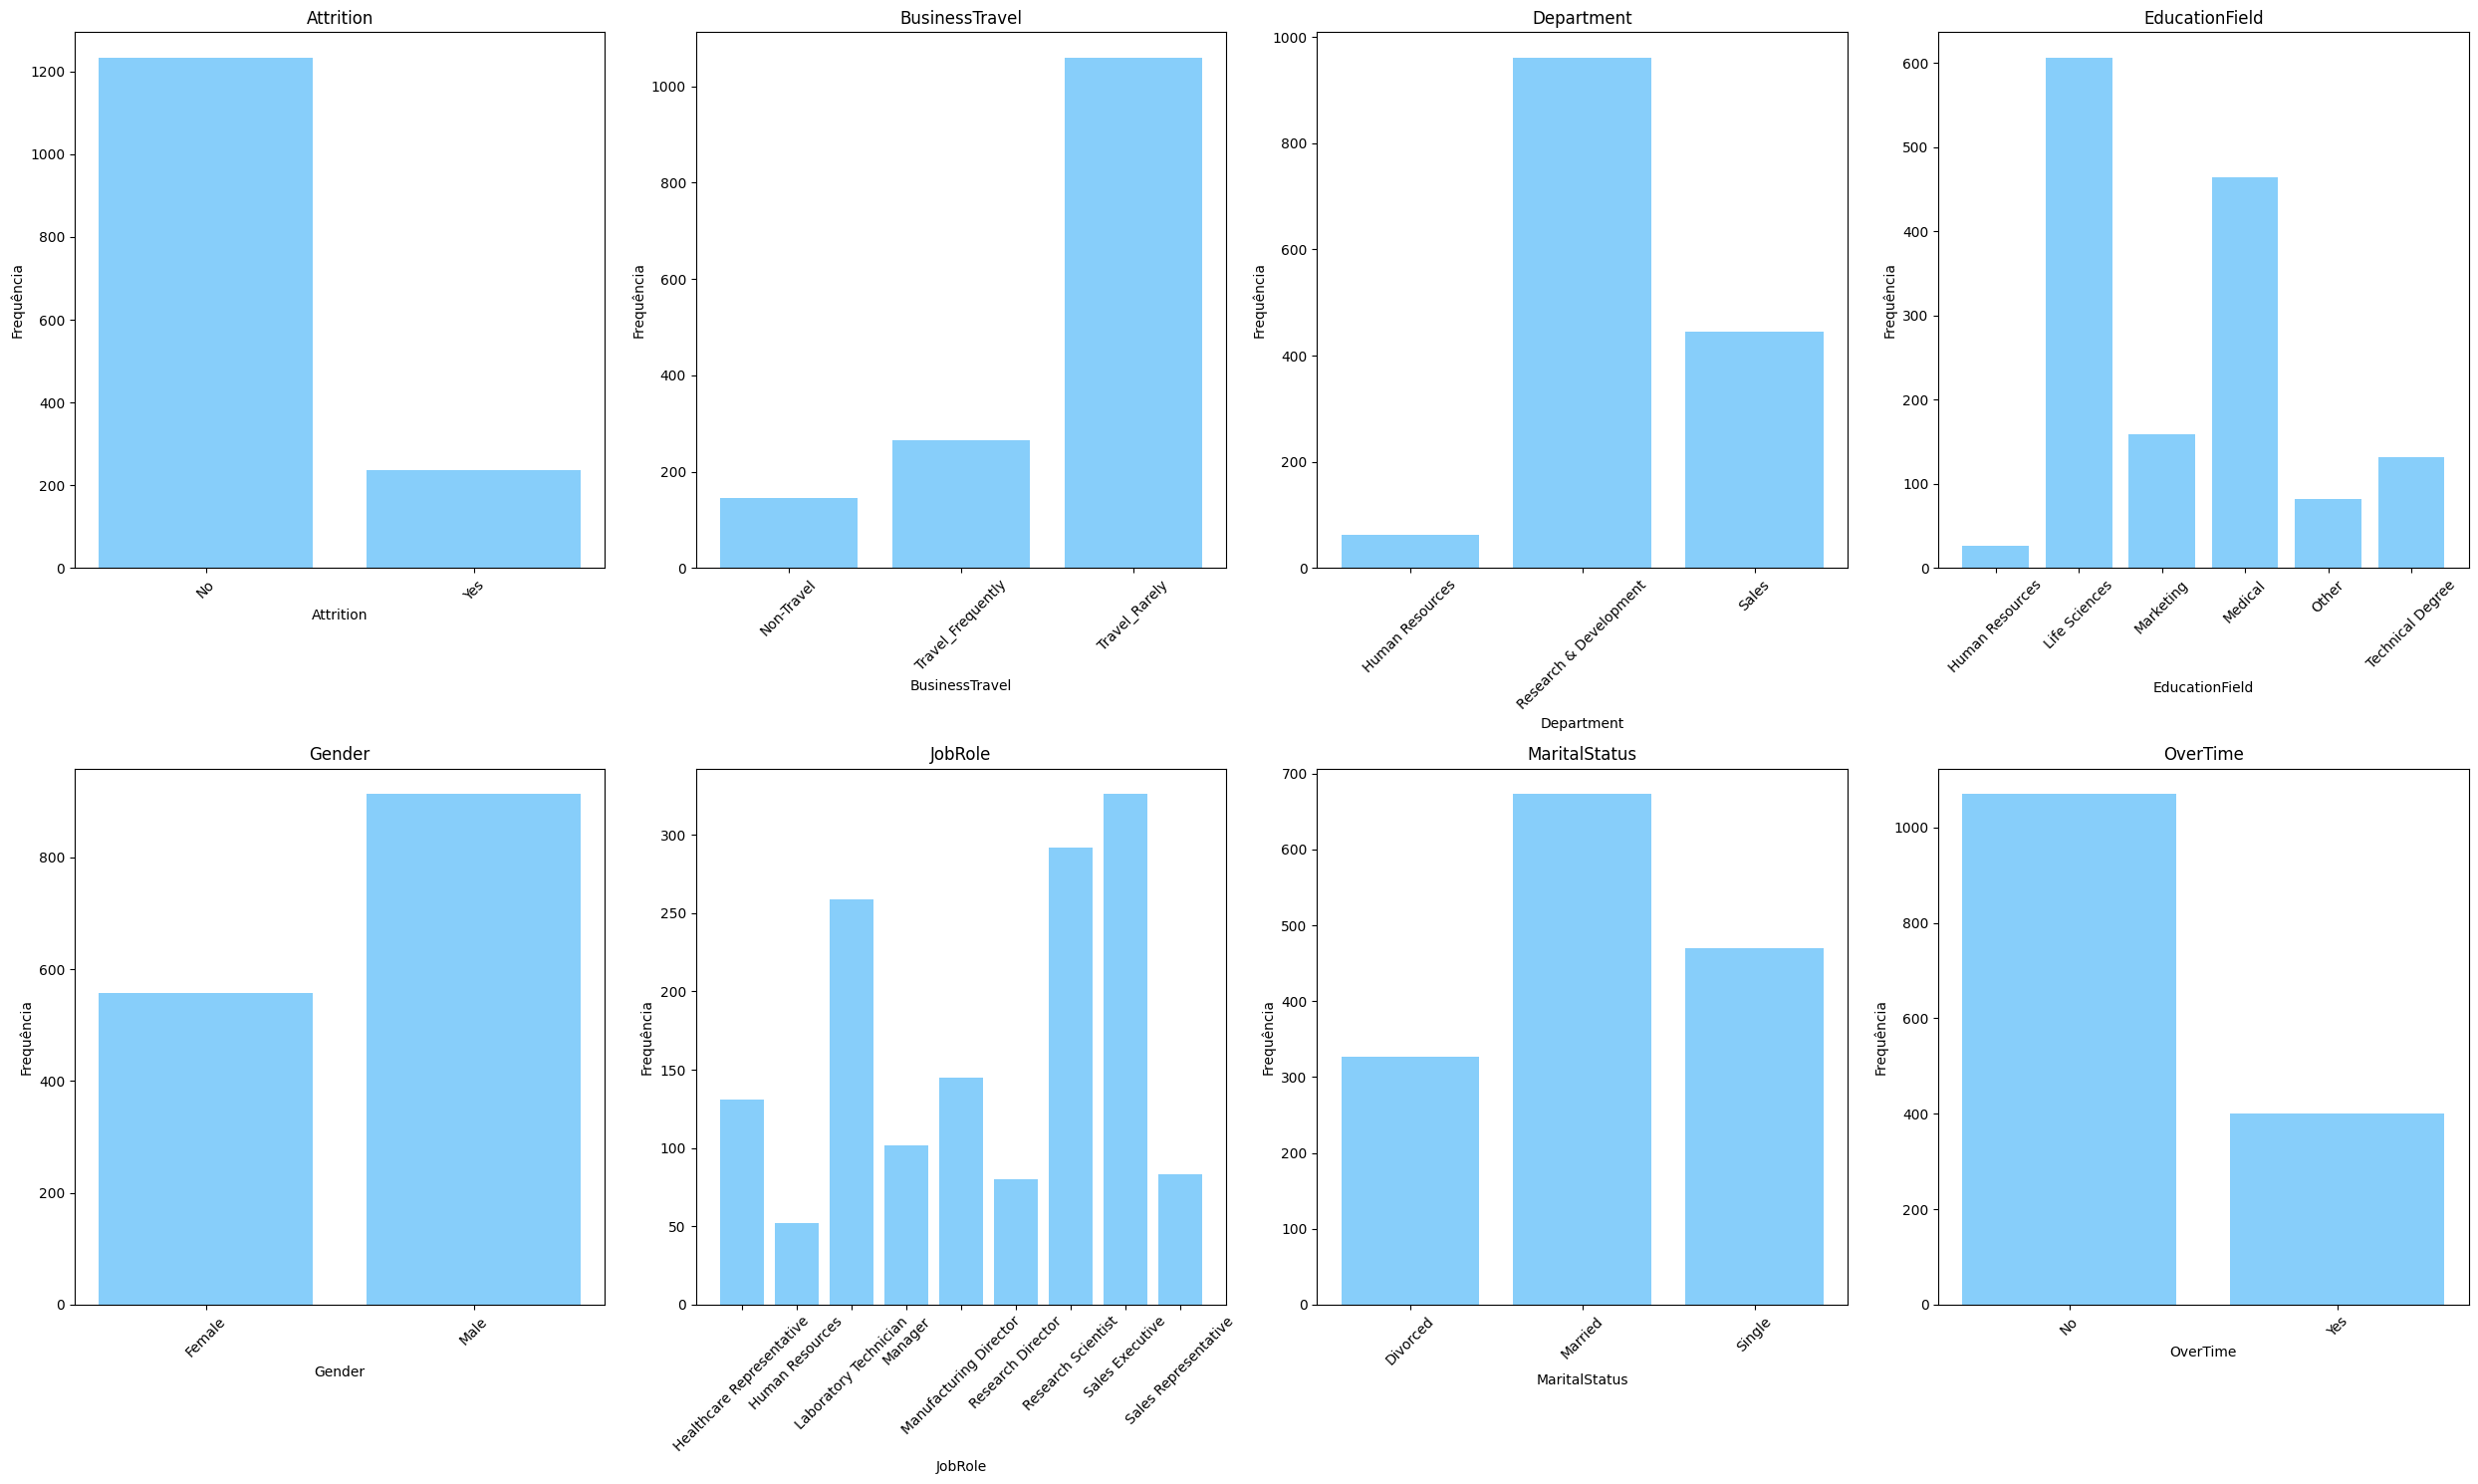

In [ ]:
grafico_frequencia(df_sem_cod)

# Análise de Normalidade
- Para analisar a normalidade dos dados, serão comparados três testes Shapiro-Wilk, Anderson-Darling e D'Agostino-Pearson


In [ ]:
"""
Faz gráficos QQ para analisar normalidade
"""
def QQ(df, col=5):
  # Determina os parâmetros da imagem
  num_cols = [col for col in df.columns if df[col].nunique() > 2]
  n = len(num_cols)
  nrows = (n + col - 1) // col  # só o necessário
  fig, axs = plt.subplots(nrows = nrows, ncols = col, figsize=(25, 30), constrained_layout = True)
  axs = axs.flatten()
  for i, col in enumerate(num_cols):
    qq = stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    teoricos = qq[0][0]
    observados = qq[0][1]
    slope, intercept = qq[1][0], qq[1][1]
    linha_ajuste = slope * teoricos + intercept
    axs[i].scatter(teoricos, observados, color='skyblue', label='Dados observados')
    axs[i].plot(teoricos, linha_ajuste, color='maroon', label='Linha de referência')
    axs[i].set_title(f"Q-Q: {col}")
    axs[i].set_xlabel("Quantis teóricos")
    axs[i].set_ylabel('Quantis da amostra')

  # Se tiver menos eixos do que colunas, esconder eixos extras
  for j in range(i+1, len(axs)):
      axs[j].set_visible(False)

  plt.show()

In [ ]:
"""
Checa a normalidade usando os testes de Shapiro-Wilk, Anderson-Darling e D'Agostino-Pearson
"""
def checar_normalidade(df):
  resultados = []
  for col in df.columns:
    values = df[col].dropna()
    # Shapiro-Wilk
    statShapiro, pShapiro = stats.shapiro(values)
    resShapiro = 1 if pShapiro > 0.05 else 0

    # Anderson-Darling
    statAD, critical, significance  = stats.anderson(values, dist='norm')
    resAD = 1 if statAD < critical[2] else 0 # Para 5%

    # D'Agostino-Pearson
    statAP, pAP = stats.normaltest(values)
    resAP = 1 if pAP > 0.05 else 0

    resultados.append({
        'coluna': col,
        'Shapiro-Wilk': pShapiro,
        'é normal (Shapiro)': resShapiro,
        'Anderson-Darling': statAD,
        'é normal (AD)': resAD,
        'DAgostino-Pearson': statAP,
        'é normal (AP)': resAP
    })
  QQ(df)
  df_normal = pd.DataFrame(resultados)
  return df_normal

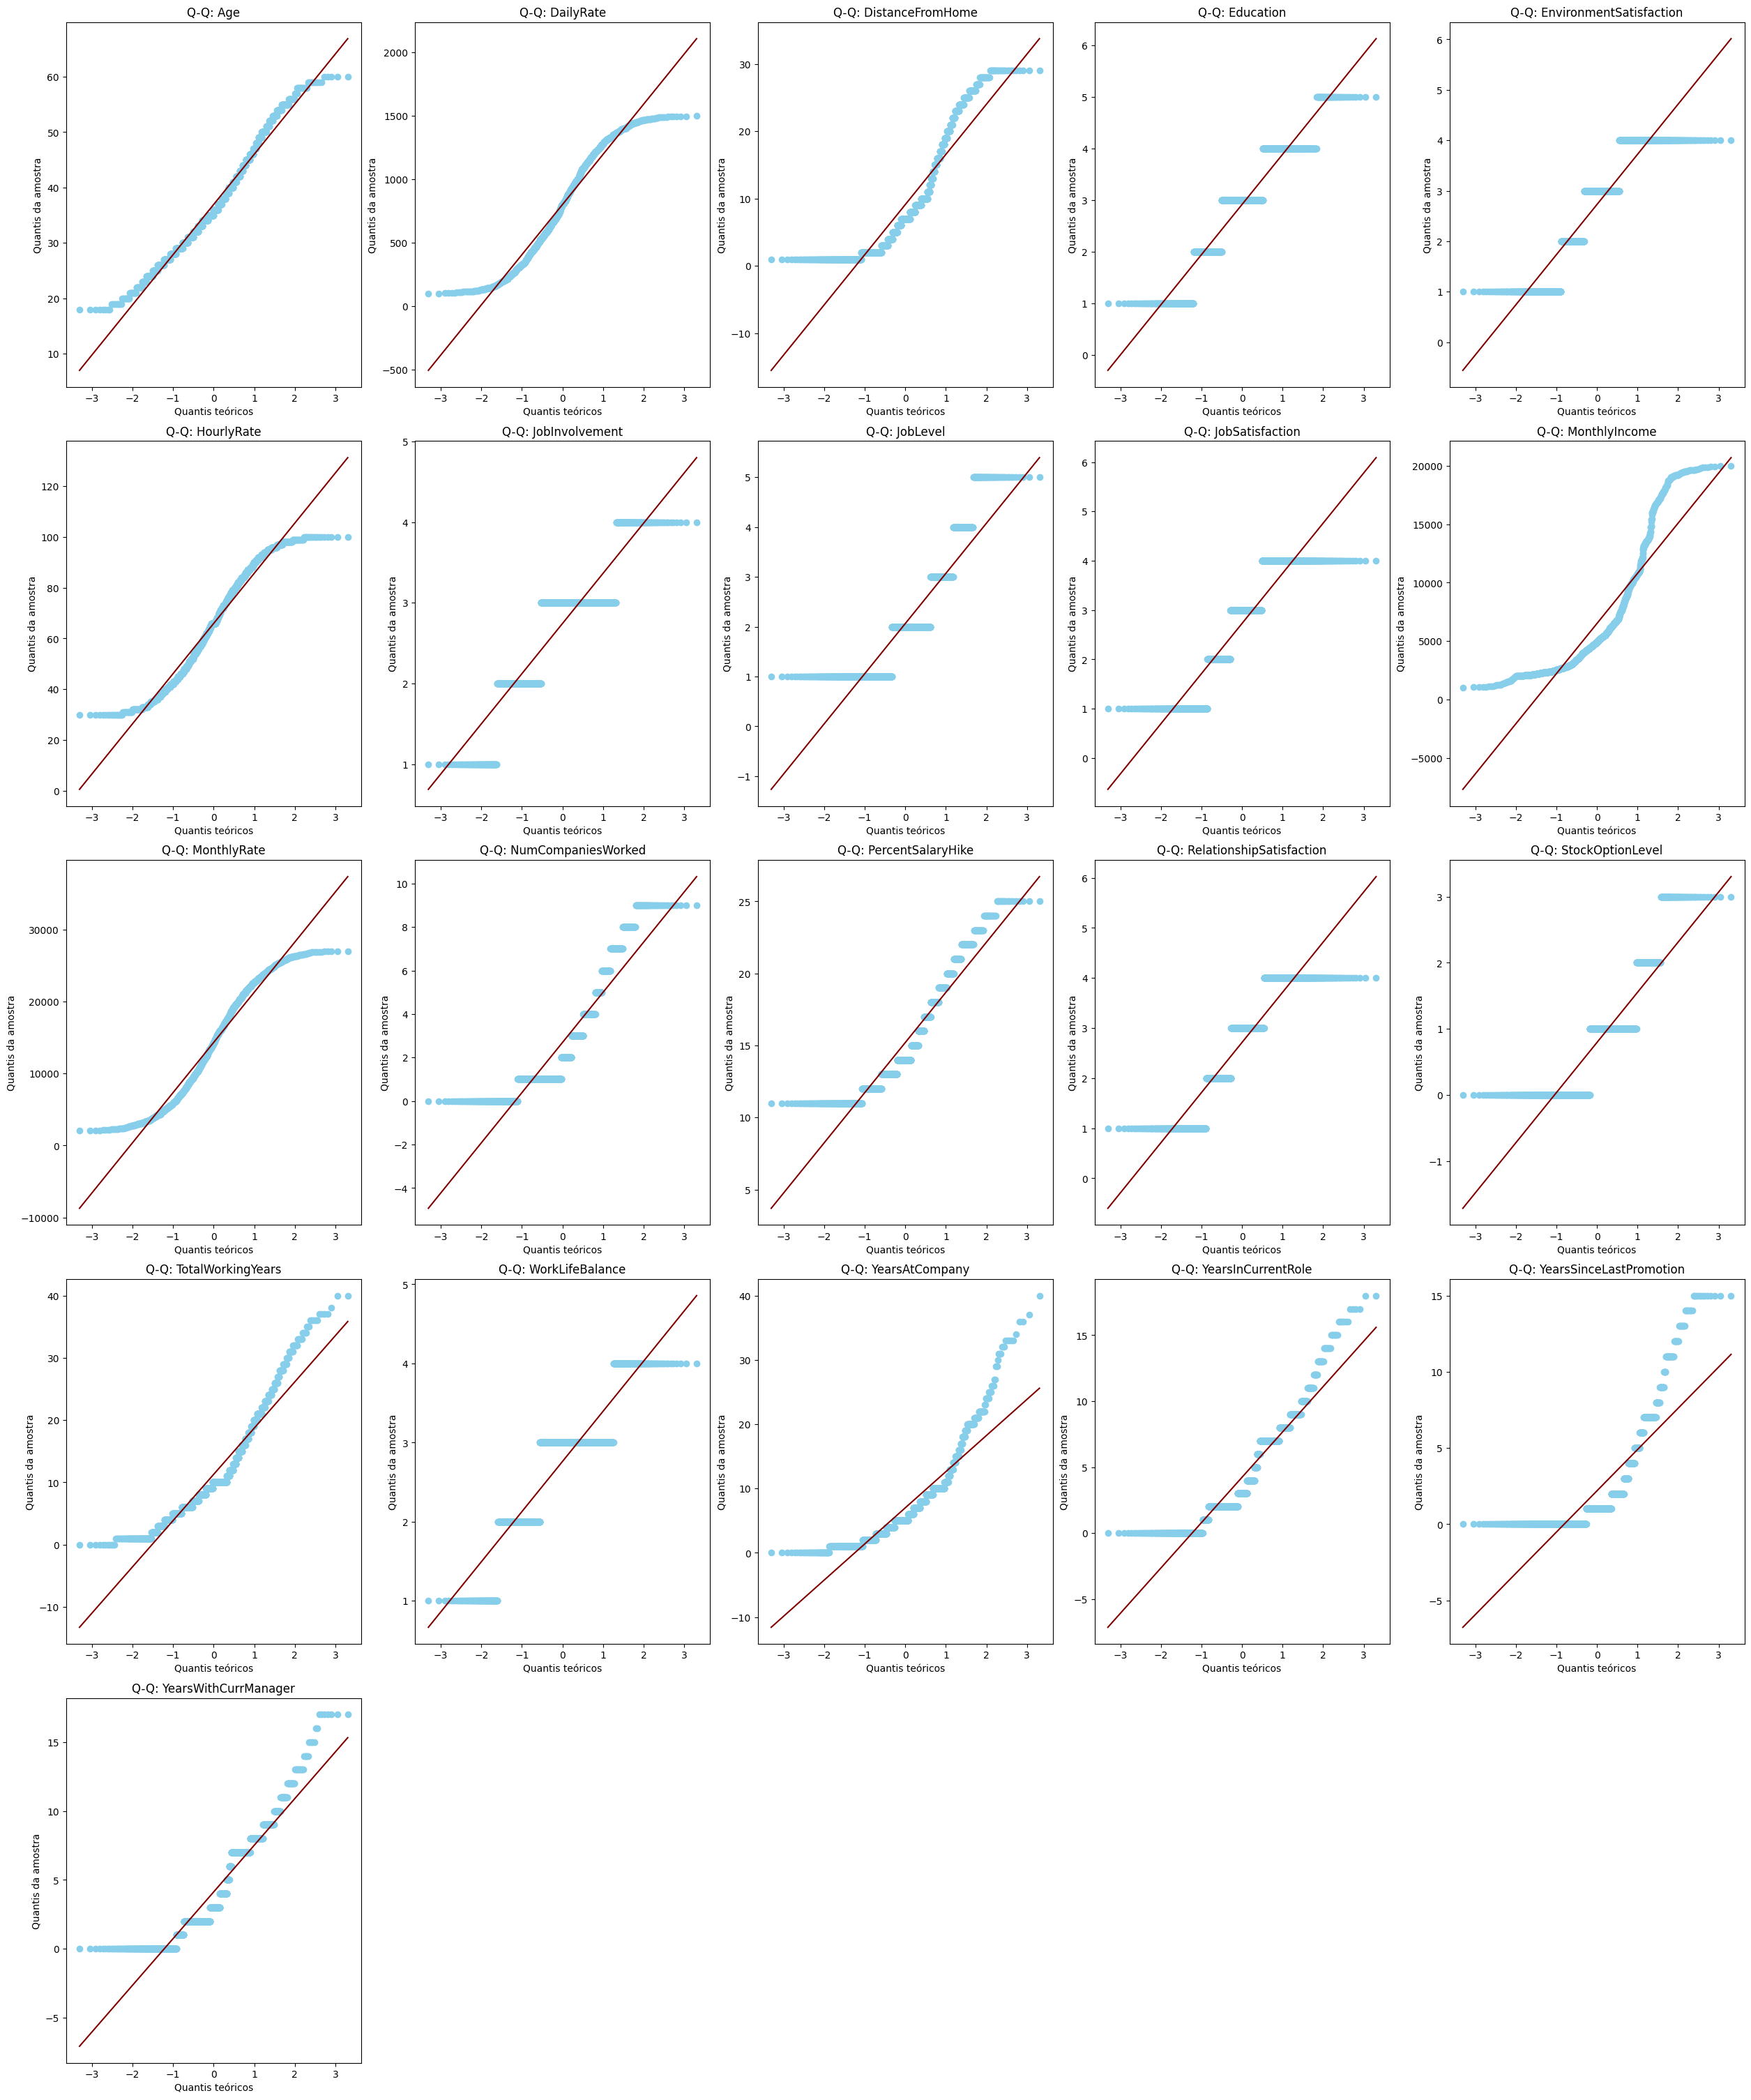

coluna  Shapiro-Wilk  é normal (Shapiro)  \
0                                 Age  2.036924e-14                   0   
1                           Attrition  2.407966e-55                   0   
2                           DailyRate  5.329330e-21                   0   
3                    DistanceFromHome  2.914104e-34                   0   
4                           Education  1.725712e-30                   0   
5             EnvironmentSatisfaction  4.238656e-35                   0   
6                              Gender  3.521334e-49                   0   
7                          HourlyRate  3.280574e-20                   0   
8                      JobInvolvement  2.176829e-39                   0   
9                            JobLevel  1.499355e-37                   0   
10                    JobSatisfaction  1.373434e-35                   0   
11                      MonthlyIncome  4.402394e-37                   0   
12                        MonthlyRate  5.516502e-21                   0   
13                 NumCompaniesWorked  2.632103e-35                   0   
14                           OverTime  1.706594e-51                   0   
15                  PercentSalaryHike  7.480740e-30                   0   
16                  PerformanceRating  5.114664e-56                   0   
17           RelationshipSatisfaction  7.030159e-35                   0   
18                   StockOptionLevel  6.100996e-40                   0   
19                  TotalWorkingYears  5.630922e-29                   0   
20                    WorkLifeBalance  4.451358e-39                   0   
21                     YearsAtCompany  3.668867e-36                   0   
22                 YearsInCurrentRole  2.142707e-30                   0   
23            YearsSinceLastPromotion  4.772965e-45                   0   
24               YearsWithCurrManager  3.055796e-30                   0   
25          BusinessTravel_Non-Travel  3.056667e-58                   0   
26   BusinessTravel_Travel_Frequently  1.425290e-54                   0   
27       BusinessTravel_Travel_Rarely  2.744062e-51                   0   
28         Department_Human Resources  1.209882e-61                   0   
29  Department_Research & Development  9.636908e-50                   0   
30                   Department_Sales  1.124123e-50                   0   
31     EducationField_Human Resources  1.358863e-63                   0   
32       EducationField_Life Sciences  9.690691e-49                   0   
33           EducationField_Marketing  8.725734e-58                   0   
34             EducationField_Medical  2.186325e-50                   0   
35               EducationField_Other  9.088648e-61                   0   
36    EducationField_Technical Degree  9.458069e-59                   0   
37  JobRole_Healthcare Representative  8.681900e-59                   0   
38            JobRole_Human Resources  3.436669e-62                   0   
39      JobRole_Laboratory Technician  9.830674e-55                   0   
40                    JobRole_Manager  6.424743e-60                   0   
41     JobRole_Manufacturing Director  2.815322e-58                   0   
42          JobRole_Research Director  7.409659e-61                   0   
43         JobRole_Research Scientist  7.125398e-54                   0   
44            JobRole_Sales Executive  4.701257e-53                   0   
45       JobRole_Sales Representative  1.005939e-60                   0   
46             MaritalStatus_Divorced  4.958119e-53                   0   
47              MaritalStatus_Married  2.305284e-48                   0   
48               MaritalStatus_Single  2.704371e-50                   0   

    Anderson-Darling  é normal (AD)  DAgostino-Pearson  é normal (AP)  
0           9.968576              0          54.684300              0  
1         425.646802              0         446.931978              0  
2          16.829262              0        1179.174873          

In [ ]:
df_normal = checar_normalidade(df_imputado)
df_normal

# Matriz de correlação
* Uso do coeficiente de Spearman, pois os dados não têm uma distribuição normal em geral

In [ ]:
"""
Cria uma matriz de correlação
df: DataFrame que será feito a matriz
metodo: qual método de correlação será usado
"""
def matriz_correlacao(df, metodo):
  print(" Matriz de correlação entre variáveis numéricas:")
  plt.figure(figsize=(30, 30))
  sns.heatmap(df_imputado.corr(method=metodo), cmap='coolwarm', center=0, annot=True, linewidths=0.5, fmt=".2f")
  plt.title("Matriz de Correlação entre Variáveis Numéricas")
  plt.show()


 Matriz de correlação entre variáveis numéricas:


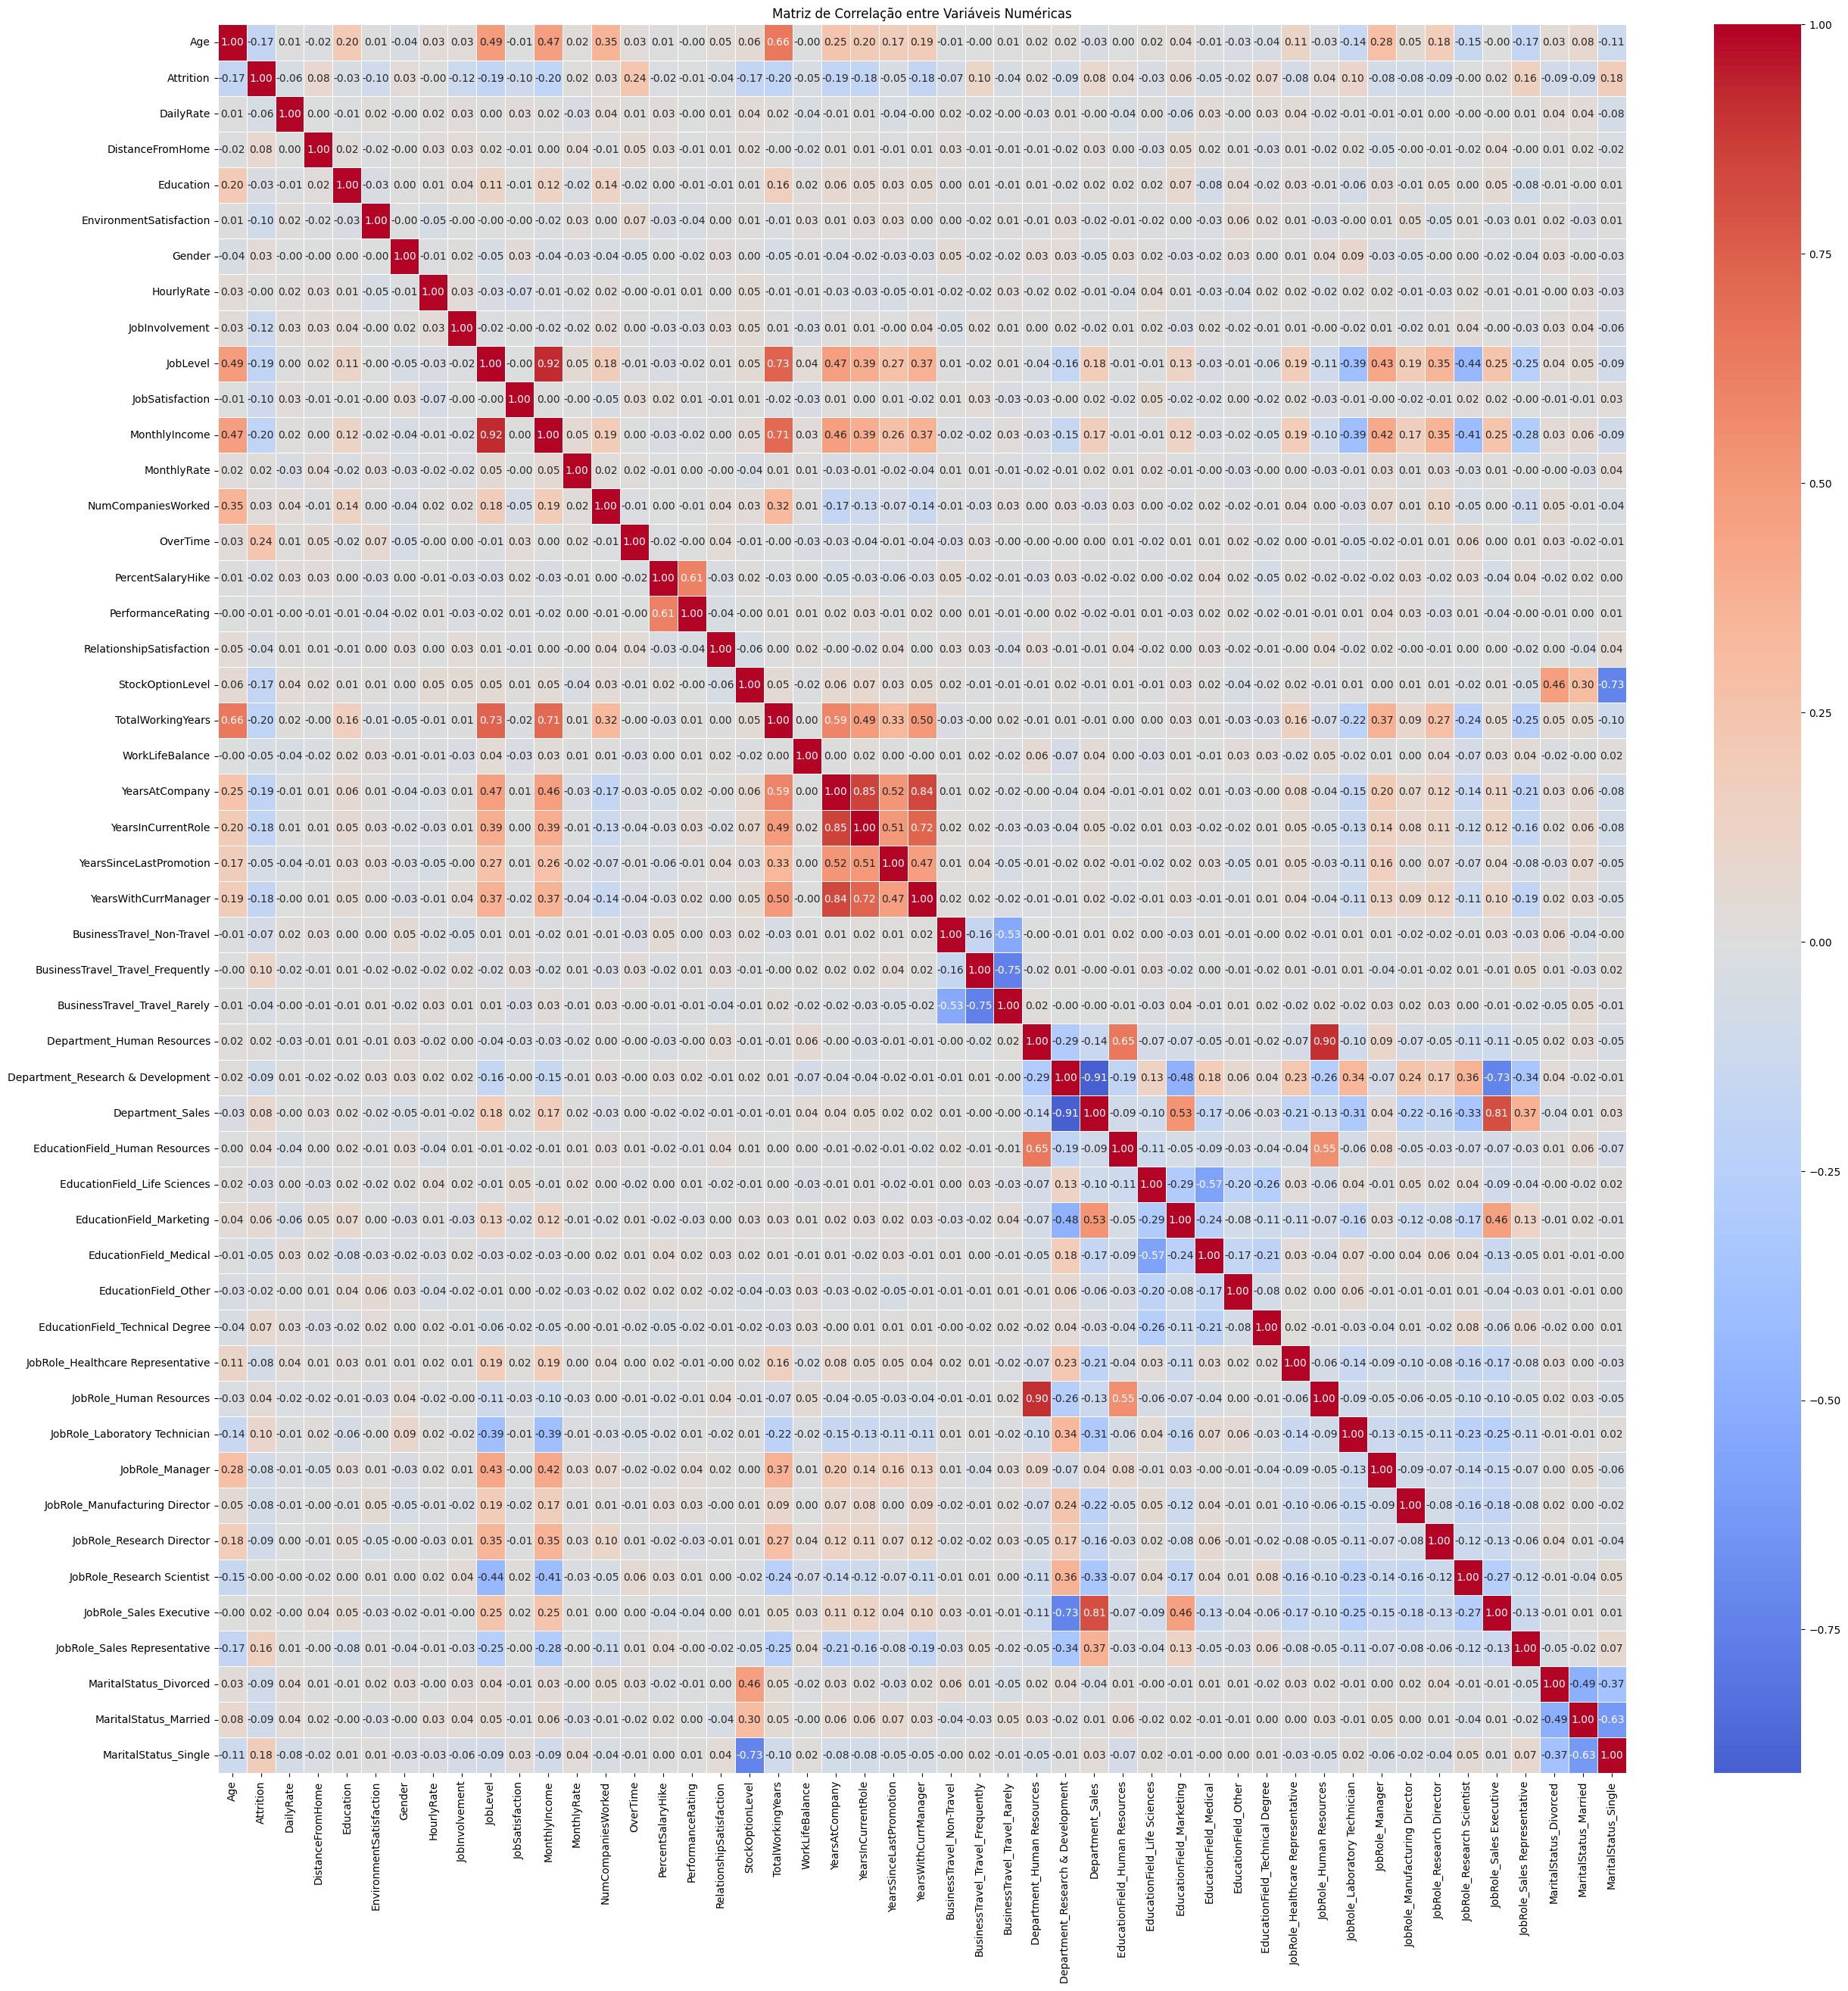

In [ ]:
matriz_correlacao(df_imputado, 'spearman')

# Violin Plot

In [ ]:
def violin_plots(df, target='Attrition', lin=10, col=5):
    # Pega colunas numéricas sem o target
    num_cols = df.select_dtypes(include='number').columns.tolist()
    num_cols.remove(target)

    fig, axs = plt.subplots(nrows=lin, ncols=col, figsize=(6*col, 5*lin), constrained_layout=True)
    axs = axs.flatten()

    for i, col in enumerate(num_cols):
        sns.violinplot(x=target, y=col, data=df, ax=axs[i],inner='box', color='skyblue')
        axs[i].set_title(f"{col} x {target}")

    # Oculta eixos não utilizados
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.show()

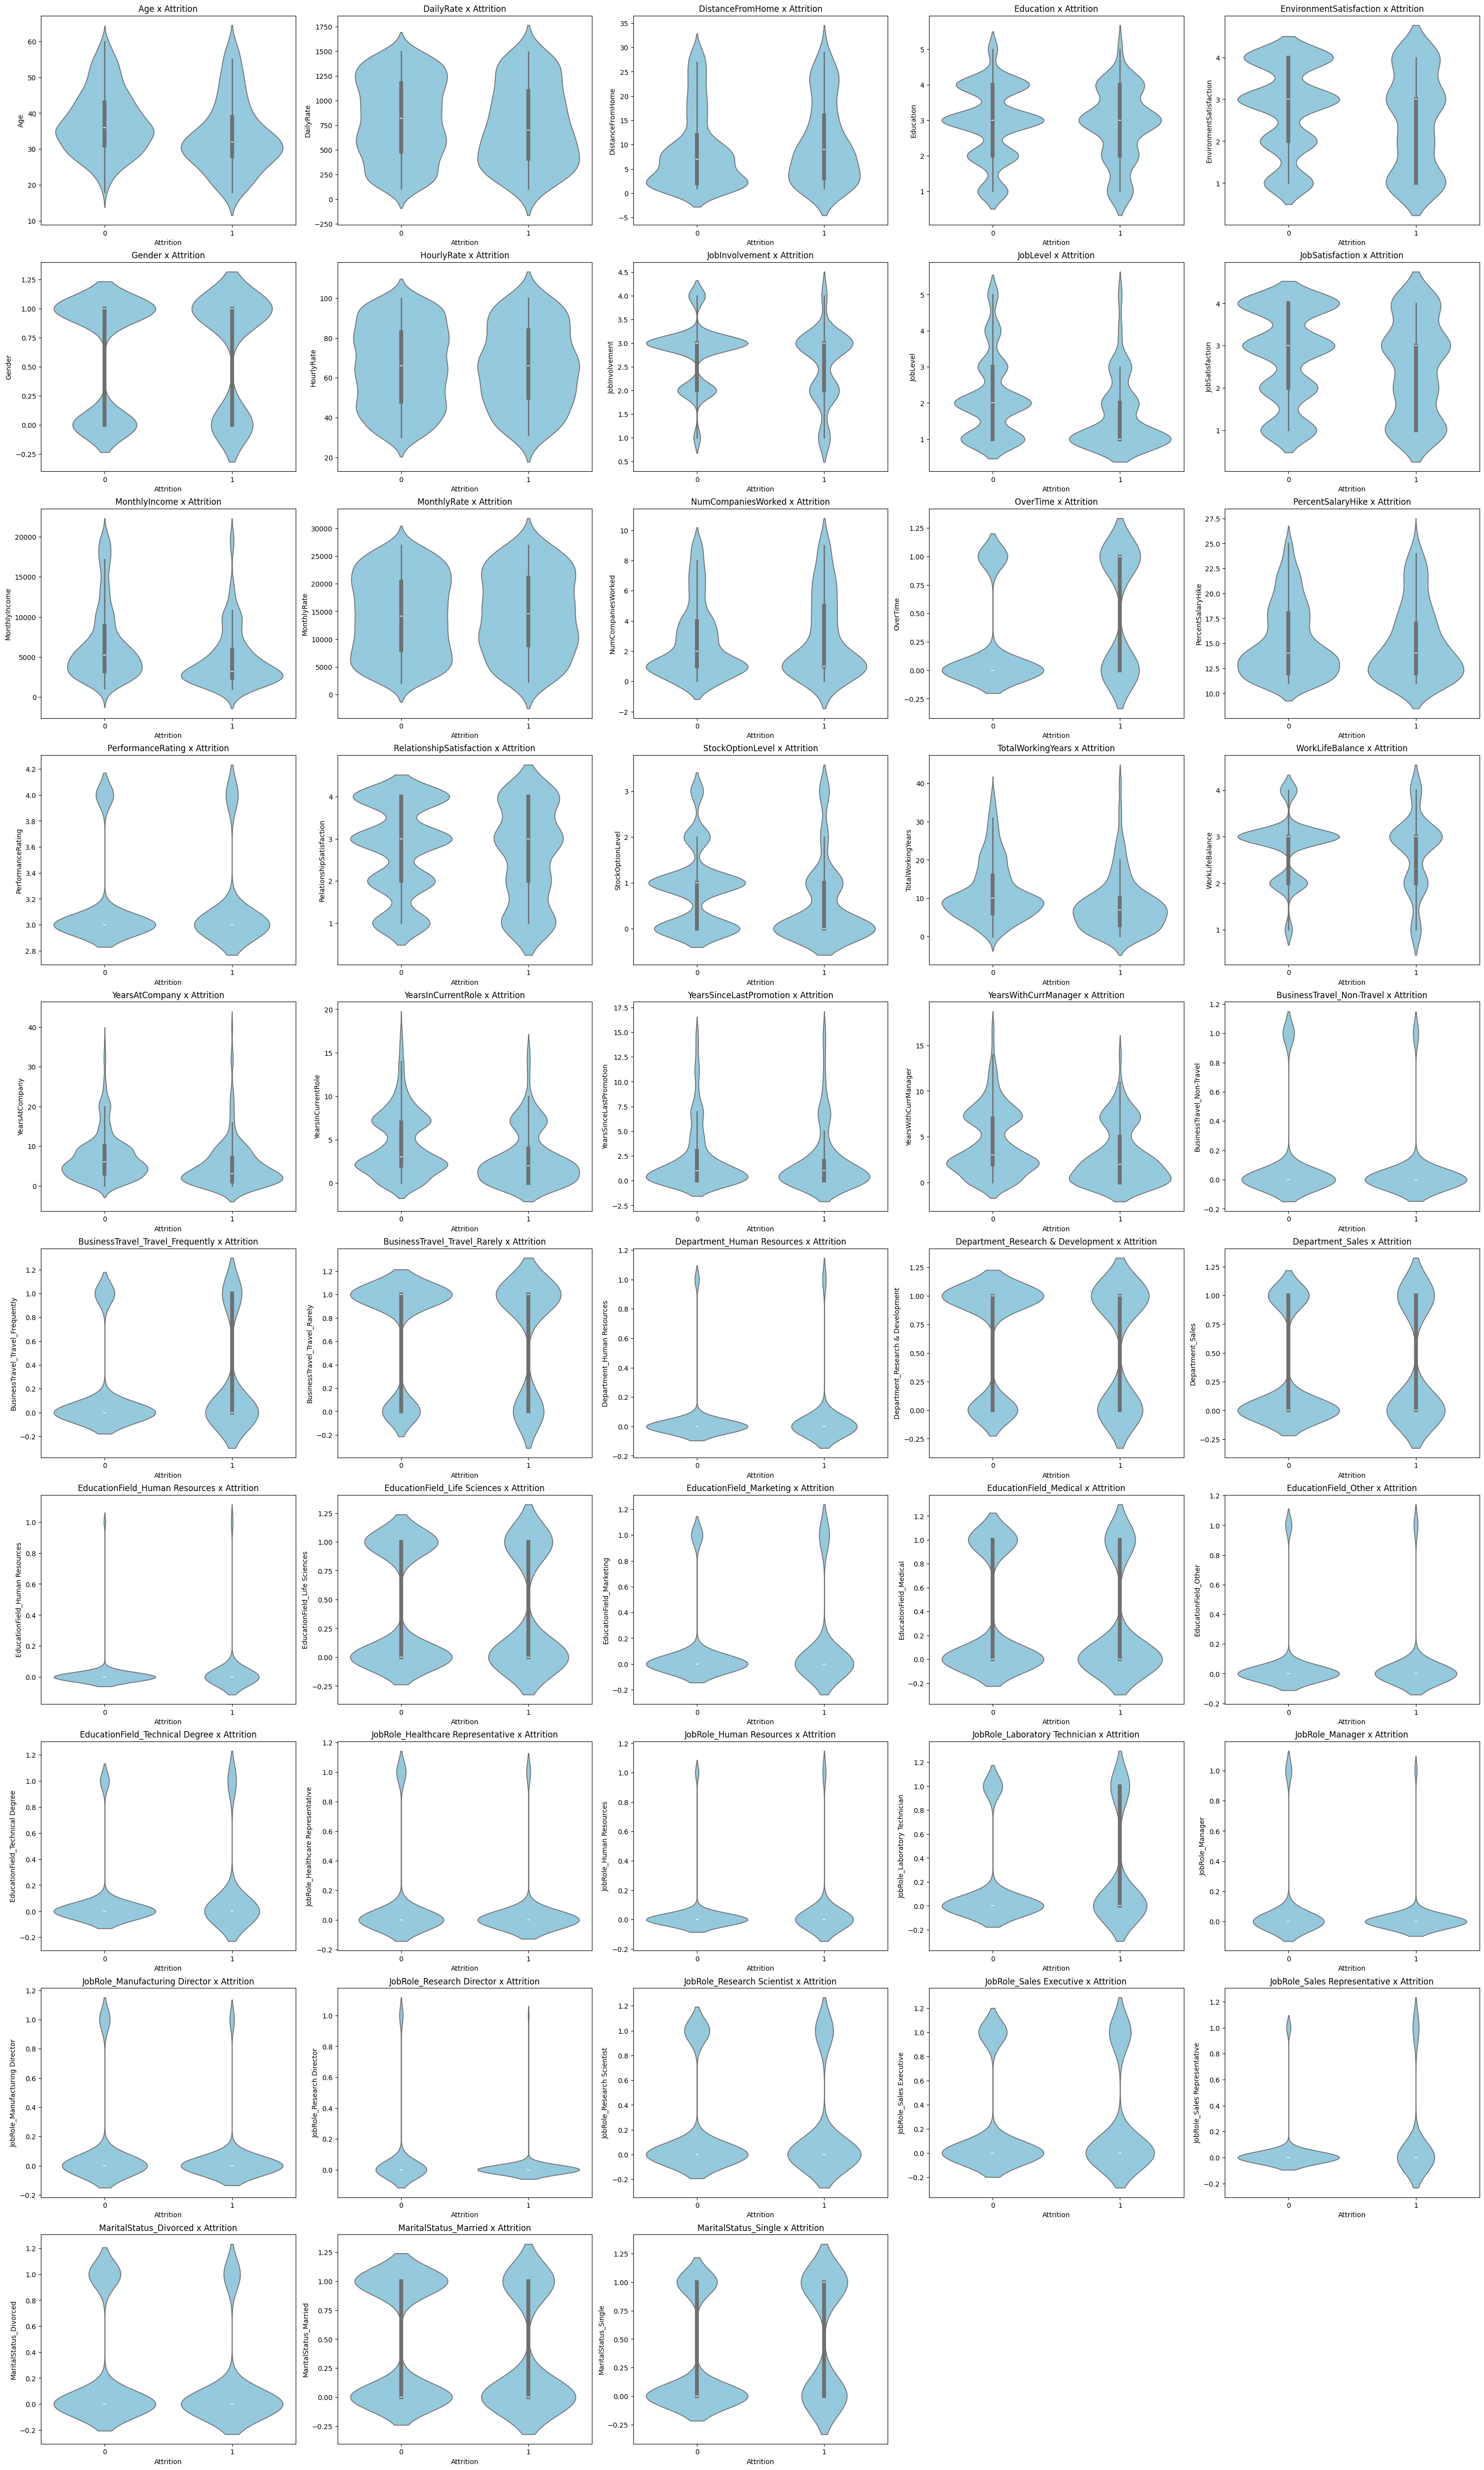

In [ ]:
violin_plots(df_imputado)

# Normalização dos dados

In [ ]:
# Normalização dos dados
for col in df_imputado.columns:
  if ((outliers_iqr(df_imputado, col).sum()) == 0):
    scaler = MinMaxScaler() # Para dados sem nenhum outliers
  else:
    scaler = RobustScaler()
  df_imputado[[col]] = scaler.fit_transform(df_imputado[[col]]) # Para dados com outliers


In [ ]:
df_imputado.describe().T

count      mean       std       min  \
Age                                1470.0  0.450567  0.217509  0.000000   
Attrition                          1470.0  0.161224  0.367863  0.000000   
DailyRate                          1470.0  0.501421  0.288840  0.000000   
DistanceFromHome                   1470.0  0.289942  0.286135  0.000000   
Education                          1470.0  0.478231  0.256041  0.000000   
EnvironmentSatisfaction            1470.0  0.575964  0.358074  0.000000   
Gender                             1470.0  0.621088  0.485281  0.000000   
HourlyRate                         1470.0  0.512993  0.288042  0.000000   
JobInvolvement                     1470.0  0.581179  0.231462  0.000000   
JobLevel                           1470.0  0.265986  0.276735  0.000000   
JobSatisfaction                    1470.0  0.576190  0.367615  0.000000   
MonthlyIncome                      1470.0  0.289673  0.861002 -0.715069   
MonthlyRate                        1470.0  0.490629  0.285797  0.000000   
NumCompaniesWorked                 1470.0  0.231066  0.832670 -0.666667   
OverTime                           1470.0  0.272109  0.445197  0.000000   
PercentSalaryHike                  1470.0  0.300680  0.261424  0.000000   
PerformanceRating                  1470.0  0.145578  0.352803  0.000000   
RelationshipSatisfaction           1470.0  0.570748  0.360403  0.000000   
StockOptionLevel                   1470.0 -0.206122  0.852077 -1.000000   
TotalWorkingYears                  1470.0  0.142177  0.864531 -1.111111   
WorkLifeBalance                    1470.0  0.587075  0.235492  0.000000   
YearsAtCompany                     1470.0  0.334694  1.021088 -0.833333   
YearsInCurrentRole                 1470.0  0.245850  0.724627 -0.600000   
YearsSinceLastPromotion            1470.0  0.395918  1.074143 -0.333333   
YearsWithCurrManager               1470.0  0.224626  0.713627 -0.600000   
BusinessTravel_Non-Travel          1470.0  0.099320  0.299193  0.000000   
BusinessTravel_Travel_Frequently   1470.0  0.180272  0.384545  0.000000   
BusinessTravel_Travel_Rarely       1470.0  0.720408  0.448951  0.000000   
Department_Human Resources         1470.0  0.042857  0.202604  0.000000   
Department_Research & Development  1470.0  0.653741  0.475939  0.000000   
Department_Sales                   1470.0  0.303401  0.459884  0.000000   
EducationField_Human Resources     1470.0  0.018367  0.134321  0.000000   
EducationField_Life Sciences       1470.0  0.412245  0.492406  0.000000   
EducationField_Marketing           1470.0  0.108163  0.310692  0.000000   
EducationField_Medical             1470.0  0.315646  0.464931  0.000000   
EducationField_Other               1470.0  0.055782  0.229579  0.000000   
EducationField_Technical Degree    1470.0  0.089796  0.285986  0.000000   
JobRole_Healthcare Representative  1470.0  0.089116  0.285008  0.000000   
JobRole_Human Resources            1470.0  0.035374  0.184786  0.000000   
JobRole_Laboratory Technician      1470.0  0.176190  0.381112  0.000000   
JobRole_Manager                    1470.0  0.069388  0.254199  0.000000   
JobRole_Manufacturing Director     1470.0  0.098639  0.298279  0.000000   
JobRole_Research Director          1470.0  0.054422  0.226925  0.000000   
JobRole_Research Scientist         1470.0  0.198639  0.399112  0.000000   
JobRole_Sales Executive            1470.0  0.221769  0.415578  0.000000   
JobRole_Sales Representative       1470.0  0.056463  0.230891  0.000000   
MaritalStatus_Divorced             1470.0  0.222449  0.416033  0.000000   
MaritalStatus_Married              1470.0  0.457823  0.498387  0.000000   
MaritalStatus_Single               1470.0  0.319728  0.466530  0.000000   

                                        25%       50%       75%       max  
Age                                0.285714  0.428571  0.595238  1.000000  
Attrition                          0.000000  0.000000  0.000000  1.000000  
DailyRate                          0.259843  0.501074  0.

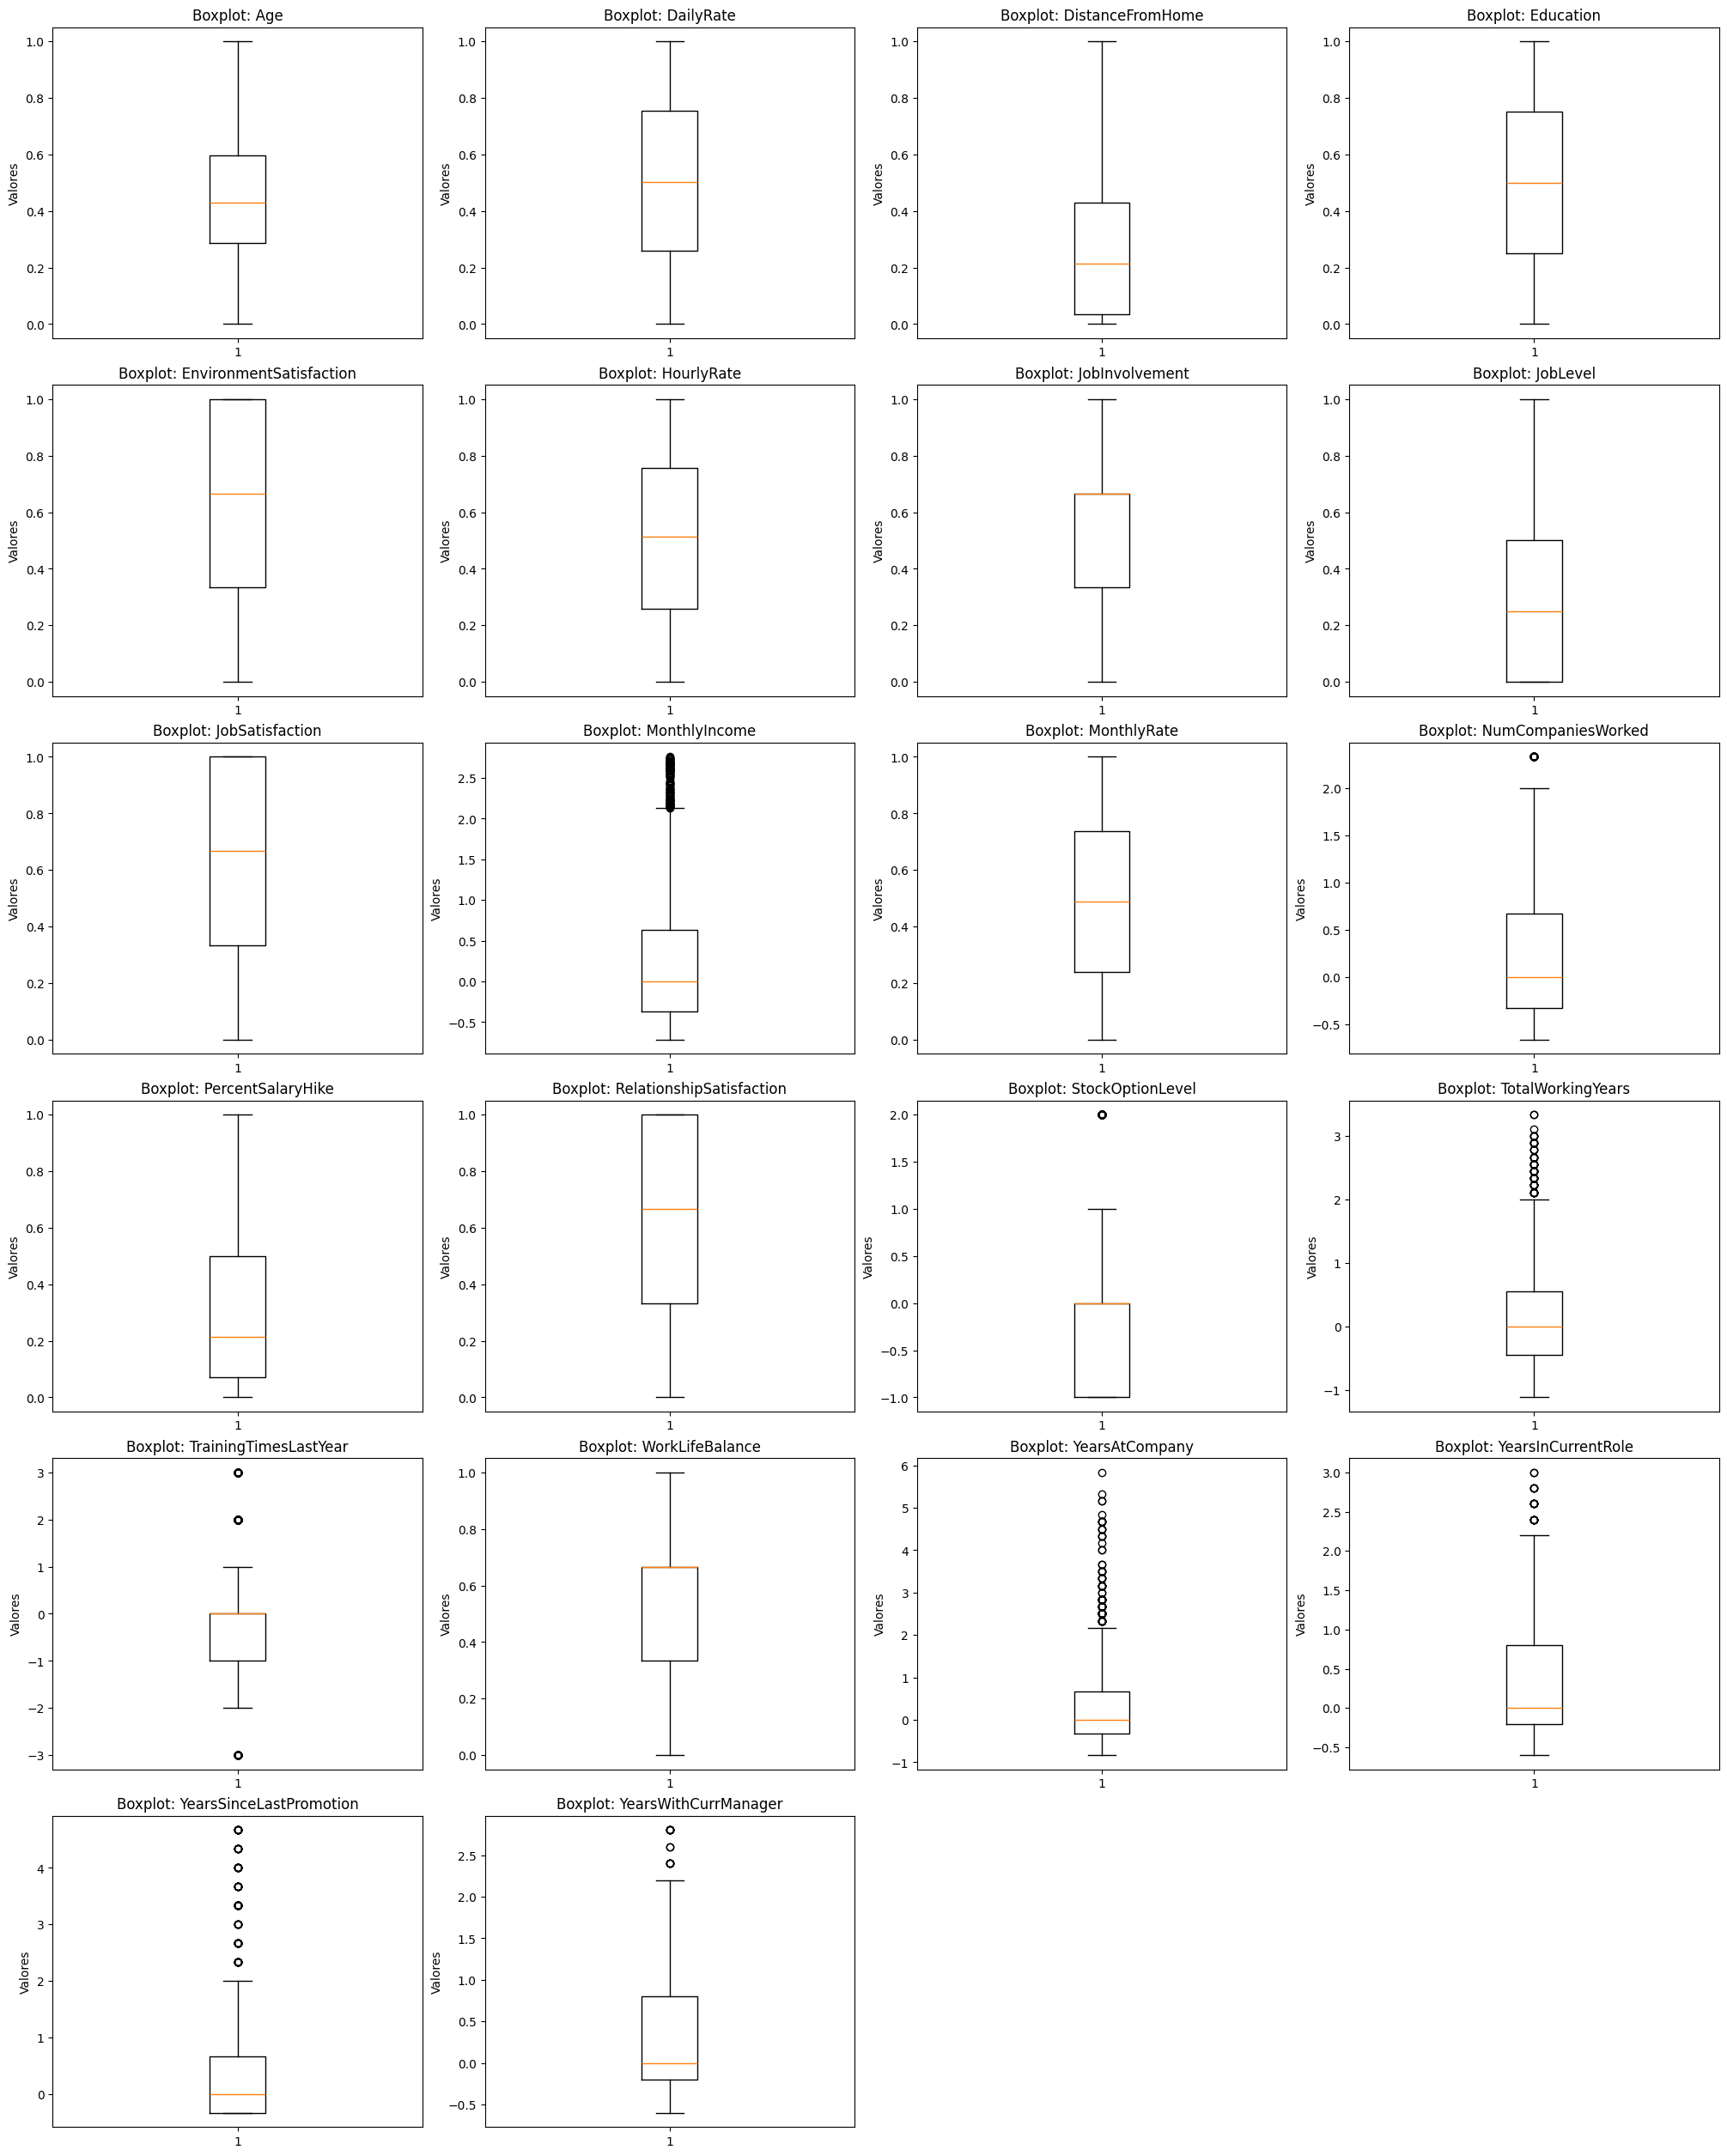

In [ ]:
BoxPlot(df_imputado, 4)

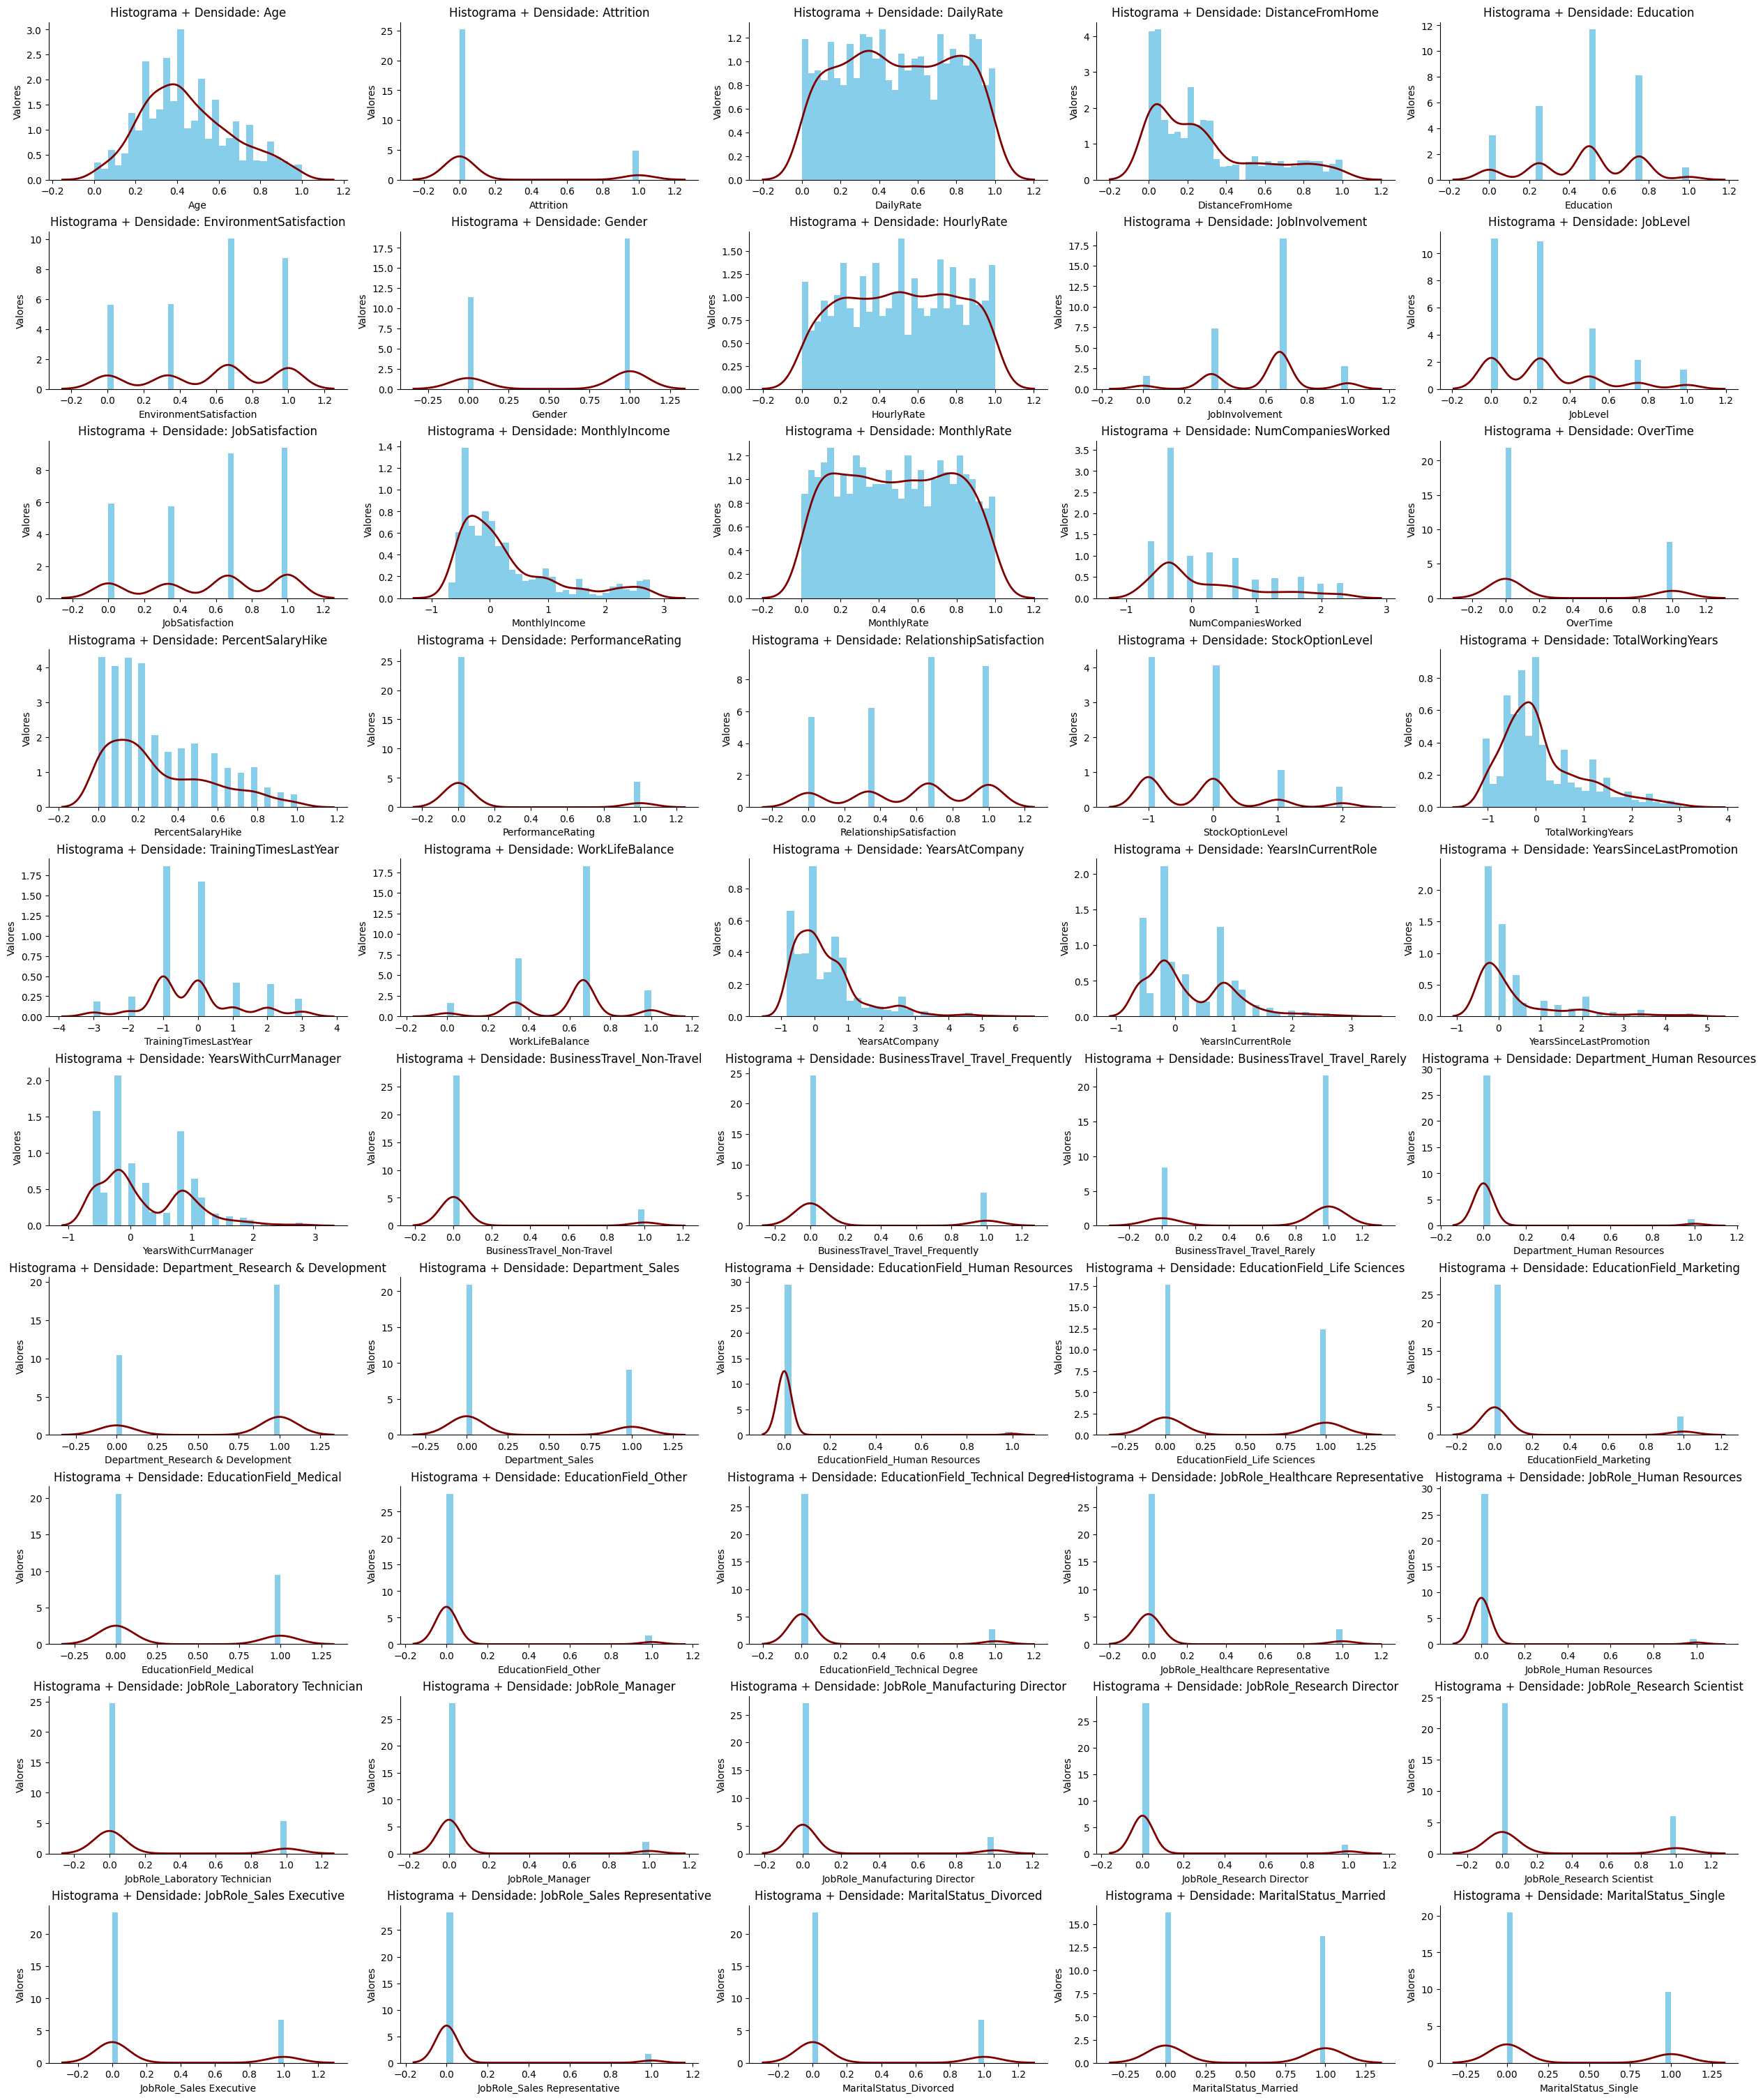

In [ ]:
Histogramas(df_imputado, 10, 5)

# Upload dos dados limpos

In [ ]:
# Exportar o DataFrame limpo e imputado para um novo CSV
df_imputado.to_csv("dados_limpos.csv", index=False)
files.download("dados_limpos.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>